In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.preprocessing import MinMaxScaler
import joblib

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

In [2]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Wahre Werte der Testdaten
y_true = df_unscaled["verbrauch"]["2021-01-01":]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Abspalten der endogenen Daten
endog_train = df_scaled["verbrauch"][:"2020-12-31"]
endog_test = df_scaled["verbrauch"]["2021-01-01":]

endog = endog_train.append(endog_test)

# <font size="7">Parameterbestimmung mit auto_arima()</font>

<font size="5">Es wird zunächst die Funktion auto_airma() verwendet, um einen geeigneten Parametersatz zu finden.</font>

## <font size="6">auto_arima()</font><a class="anchor" id="4-02a-auto_arima"></a>

<font size="5">Die Funktion ermittelt ein ARIMA(2,0,2)(2,0,2)7 als bestes Modell. Es ist dabei zu erkennen, dass die Funktion höchstens Module dritter Ordnung verwendet. Darüber hinaus scheinen zusätzliche Lags keine ausreichenden Verbesserungen zu erzielen.</font>

In [3]:
model = auto_arima(y=endog, seasonal=True, m=7, d=0, D=0, information_criterion="aic", trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-5830.350, Time=4.60 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-705.558, Time=0.20 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-4833.713, Time=1.79 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-3350.364, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4297.801, Time=0.11 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-3440.116, Time=3.71 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-4797.181, Time=3.95 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=-5824.050, Time=7.09 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=-5777.461, Time=9.22 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-2210.906, Time=1.99 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=-3938.336, Time=7.21 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=-5236.242, Time=6.53 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=-5948.055, Time=10.27 sec
 ARIMA(1,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=8.71 sec
 ARIMA(2,0,1)(2,0,2)[7] in

## <font size="6">ARIMA(2,0,2)(2,0,2)7</font><a class="anchor" id="4-02a-ARIMA(2,0,2)(2,0,2)7"></a>

<font size="5">Mit einem MAPE von 3,21% ist das Modell bereits sehr nah an den tatsächlichen Werten. Die wöchentliche und jährliche Saisonalität kann gut erfasst werden. Die Log-Likelihood von 3.038 und das AIC von -6.058 lassen sich nicht absolut interpretieren und können daher erst im Kontext weiterer Modelle bewertet werden. In der Spalte „P>|Z|“ lassen sich die p-Werte der einzelnen Koeffizienten der Module ablesen. Es ist zu erkennen, dass einzelne Koeffizienten insignifikant sind. Das bedeutet zwar nicht zwangsweise, dass diese Koeffizienten keine Generalisierung erzielen, allerdings bietet es sich an, ein Modell ohne die insignifikanten Lags zu testen.</font>

In [7]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                3037.805
Date:                           Thu, 03 Feb 2022   AIC                          -6057.610
Time:                                   10:32:49   BIC                          -6004.991
Sample:                               01-01-2015   HQIC                         -6038.529
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9434      0.050     18.823      0.000       0.845       1.042
ar.L2          0.0162      0.045      0.358

      Vorhersage
R2          0.89
MAE       5379.0
MSE   77296958.0
RMSE      8792.0
                
MAPE      3.21 %


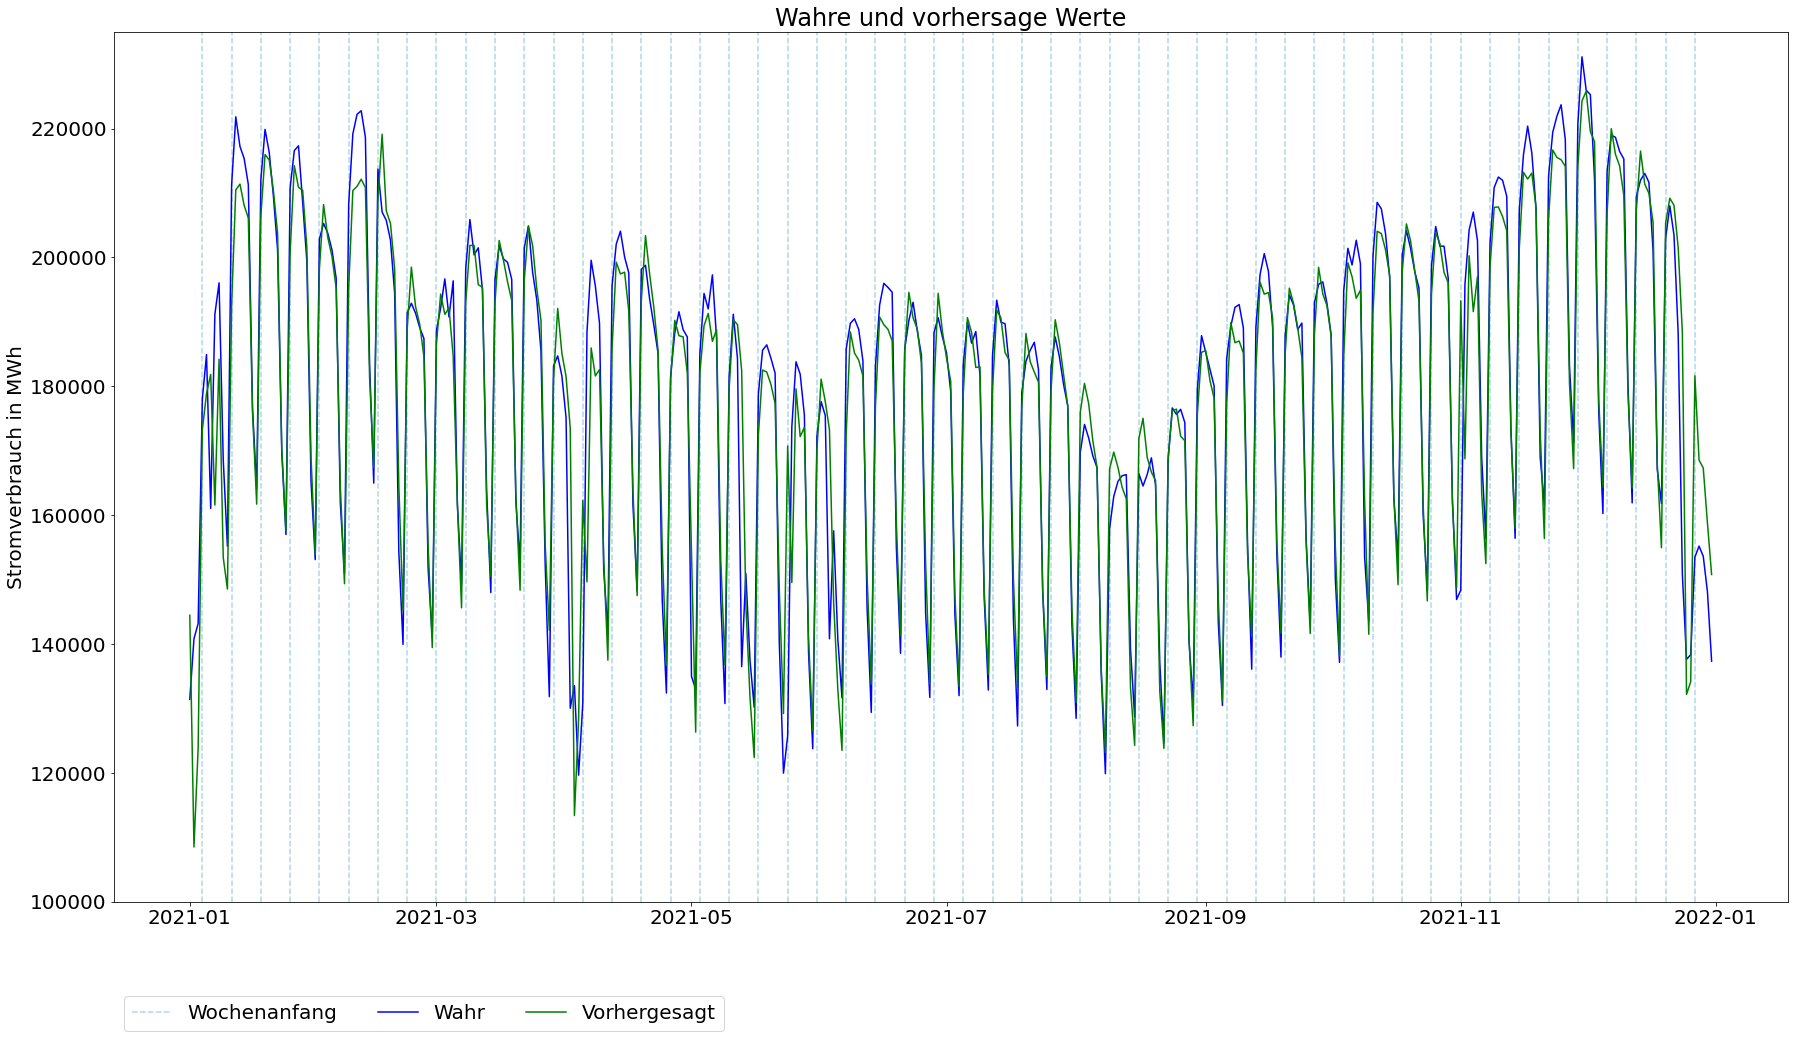

In [8]:
#Vorhersage erzeugen
scaled_preds = model.predict(start="2021-01-01", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds)

### <font size="6">ARIMA(1,0,2)([2],0,[2])7</font><a class="anchor" id="4-02a-ARIMA(1,0,2)([2],0,[2])7"></a>

<font size="5">Es werden das zweie Lag beim AR-Modul und die ersten Lags bei den SAR- und SMA-Modulen entfernt. Dadurch verschlechtern sich MAPE, Log-Likelihood und AIC ein wenig. Die Lags werden zwar als insignifikant erkannt, allerdings scheint es sich nicht um einen Fall von Überanpassung zu handeln. Außerdem fällt auch das AIC, die zusätzlichen Lags scheinen dem Modell also doch einen gewissen Informationsgehalt zu bieten.</font>

In [9]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (1, 0, 2) #p, d, q
seasonal_order = ([2], 0, [2], 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                      SARIMAX Results                                      
Dep. Variable:                           verbrauch   No. Observations:                 2557
Model:             SARIMAX(1, 0, 2)x([2], 0, 2, 7)   Log Likelihood                2971.115
Date:                             Thu, 03 Feb 2022   AIC                          -5930.231
Time:                                     10:32:54   BIC                          -5895.151
Sample:                                 01-01-2015   HQIC                         -5917.510
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999   8.16e-05   1.23e+04      0.000       1.000       1.000
ma.L1         -0.2655      

      Vorhersage
R2          0.89
MAE       5521.0
MSE   80000959.0
RMSE      8944.0
                
MAPE      3.32 %


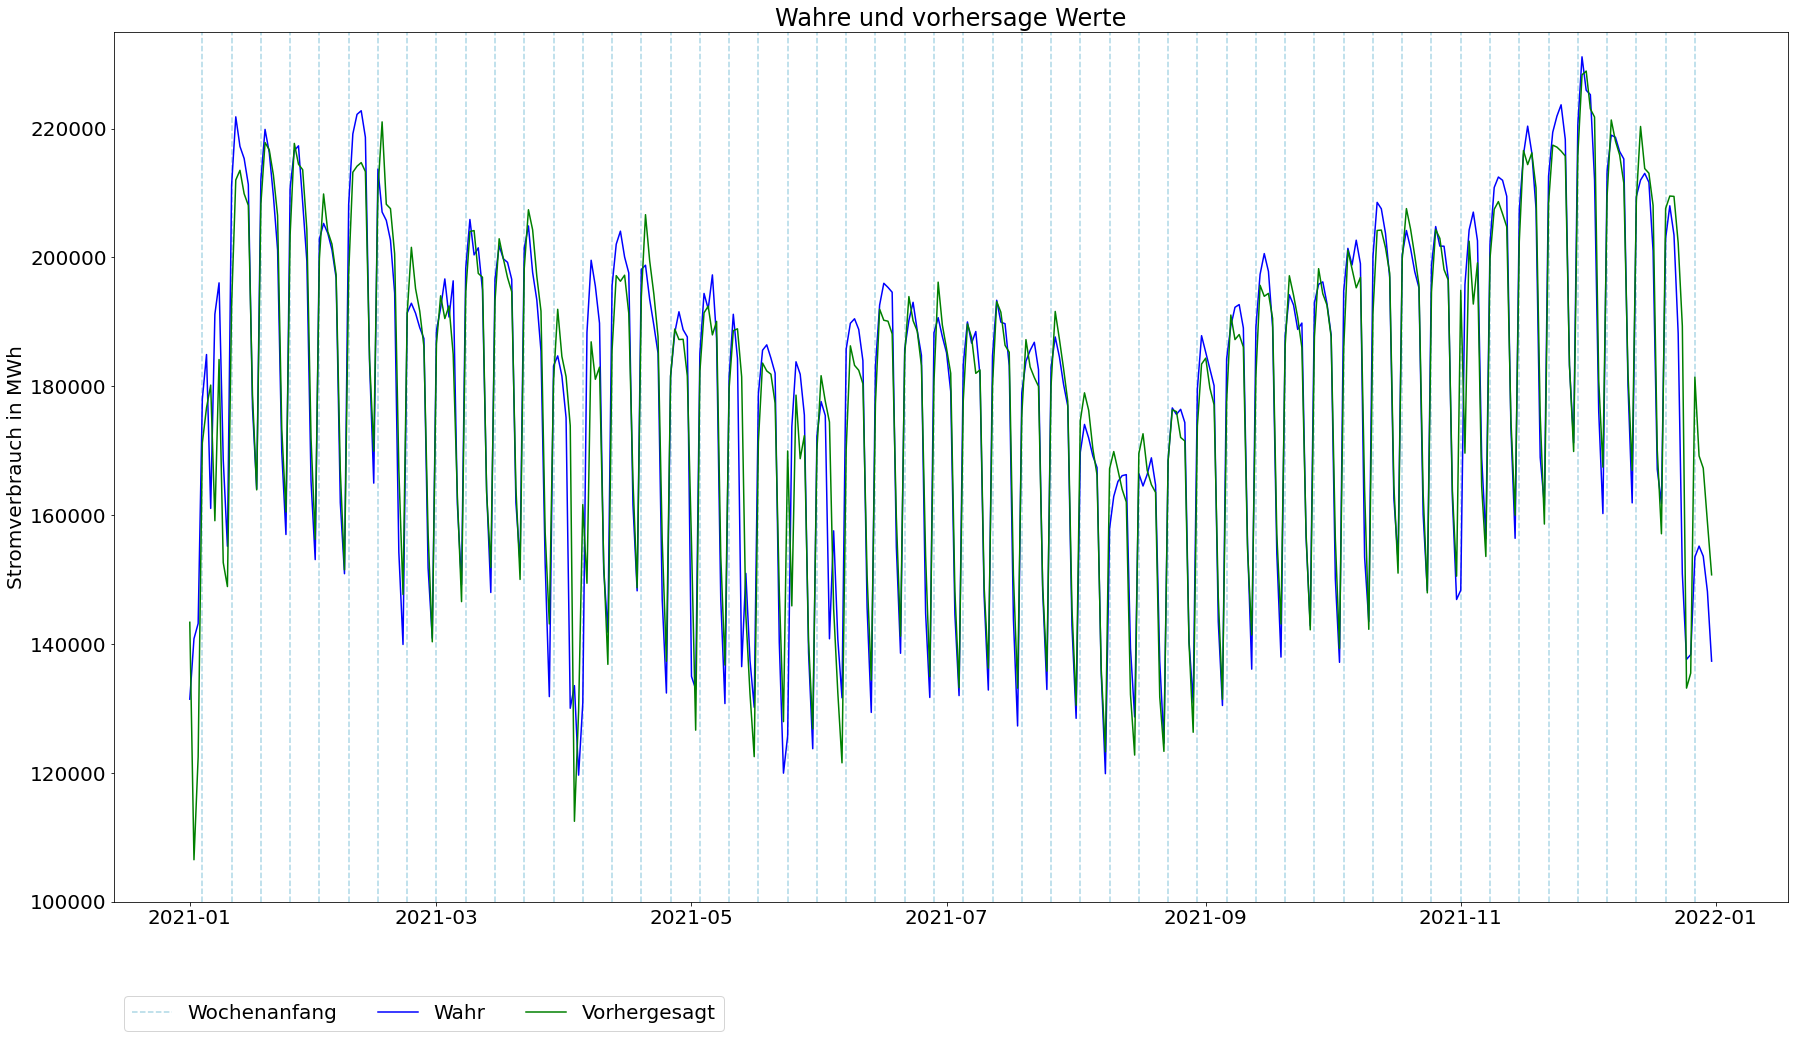

In [10]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

# <font size="7">Verbesserung durch zusätzliche Lags (mit ACF/PACF)</font><a class="anchor" id="4-02a-acfpacf"></a>

<font size="5">Die von der auto_arima()-Funktion ermittelten Parameter erzielen zwar gute Ergebnisse, allerdings ist die Funktion selbstverständlich nicht zu 100 % zuverlässig. Es wird daher weiterhin versucht, mit Hilfe der ACF/PACF und der Auswertung der einzelnen Modelle eine Ordnung zu finden, die bessere Ergebnisse erzielt.</font>

## <font size="6">ARIMA(3,0,3)(3,0,3)7</font><a class="anchor" id="4-02a-ARIMA(3,0,3)(3,0,3)7"></a>

<font size="5">Wenn die dritten Ordnungen der Module verwendet werden, führt dies zu keiner Verbesserung des Modells. Der MAPE fällt auf 3,25%, Die Log-Likelihood fällt auf 3.003 ab und auch das AIC steigt auf -5.979. Es handelt sich zwar um eine leichte Verbesserung im Vergleich zum ARIMA(1,0,2)([2],0,[2])7, jedoch kann das initiale Modell ARIMA(2,0,2)(2,0,2) nicht übertroffen werden, obwohl sehr viel mehr Lags benutzt werden. Obwohl die Log-Likelihood im Vergleich zum initialen Modell fällt, kann eine Überanpassung nicht ausgeschlossen werden, da sehr viele Koeffizienten insignifikant sind.</font>

In [11]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (3, 0, 3) #p, d, q
seasonal_order = (3, 0, 3, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 7)   Log Likelihood                3002.533
Date:                           Thu, 03 Feb 2022   AIC                          -5979.065
Time:                                   10:39:25   BIC                          -5903.060
Sample:                               01-01-2015   HQIC                         -5951.503
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2915      0.068     33.749      0.000       2.158       2.425
ar.L2         -1.8116      0.120    -15.130

      Vorhersage
R2          0.89
MAE       5451.0
MSE   78895422.0
RMSE      8882.0
                
MAPE      3.25 %


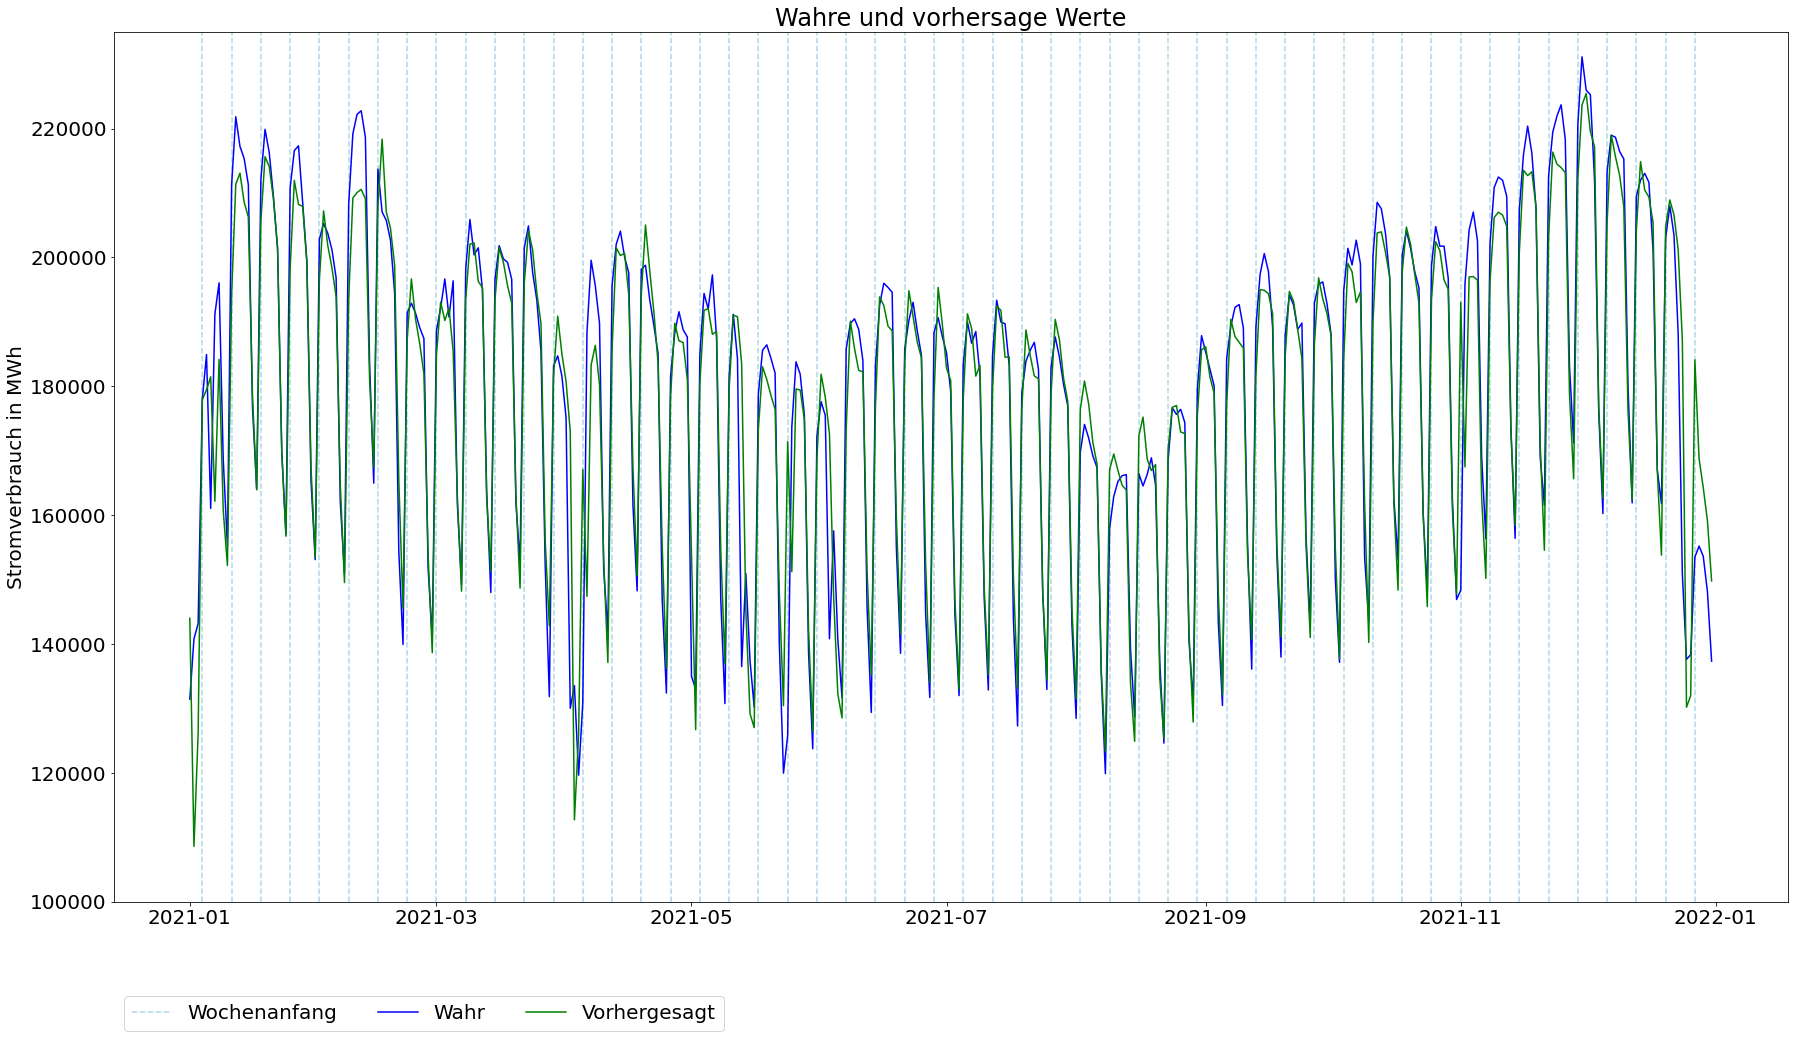

In [12]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(3,0,2)(0,0,0)7</font>

<font size="5">Werden die insignifikanten Lags aus dem ARIMA(3,0,3)(3,0,3)7 entfernt, nimmt die Güte des Modells sehr stark ab. Es werden praktisch die gesamten saisonalen Komponenten deaktiviert. Dadurch steigt der MAPE auf über 9%, Log-Likelihood und AIC sind ebenfalls sehr schlecht.</font>

In [13]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (3, 0, 2) #p, d, q
seasonal_order = (0, 0, 0, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                               SARIMAX Results                                
Dep. Variable:              verbrauch   No. Observations:                 2557
Model:               SARIMAX(3, 0, 2)   Log Likelihood                1103.072
Date:                Thu, 03 Feb 2022   AIC                          -2194.143
Time:                        10:41:49   BIC                          -2159.064
Sample:                    01-01-2015   HQIC                         -2181.422
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5549      0.001    822.152      0.000       0.554       0.556
ar.L2         -0.5538      0.001   -756.270      0.000      -0.555      -0.552
ar.L3          0.9988      0.001   1637.052      0.0

       Vorhersage
R2           0.46
MAE       16592.0
MSE   374061878.0
RMSE      19341.0
                 
MAPE       9.34 %


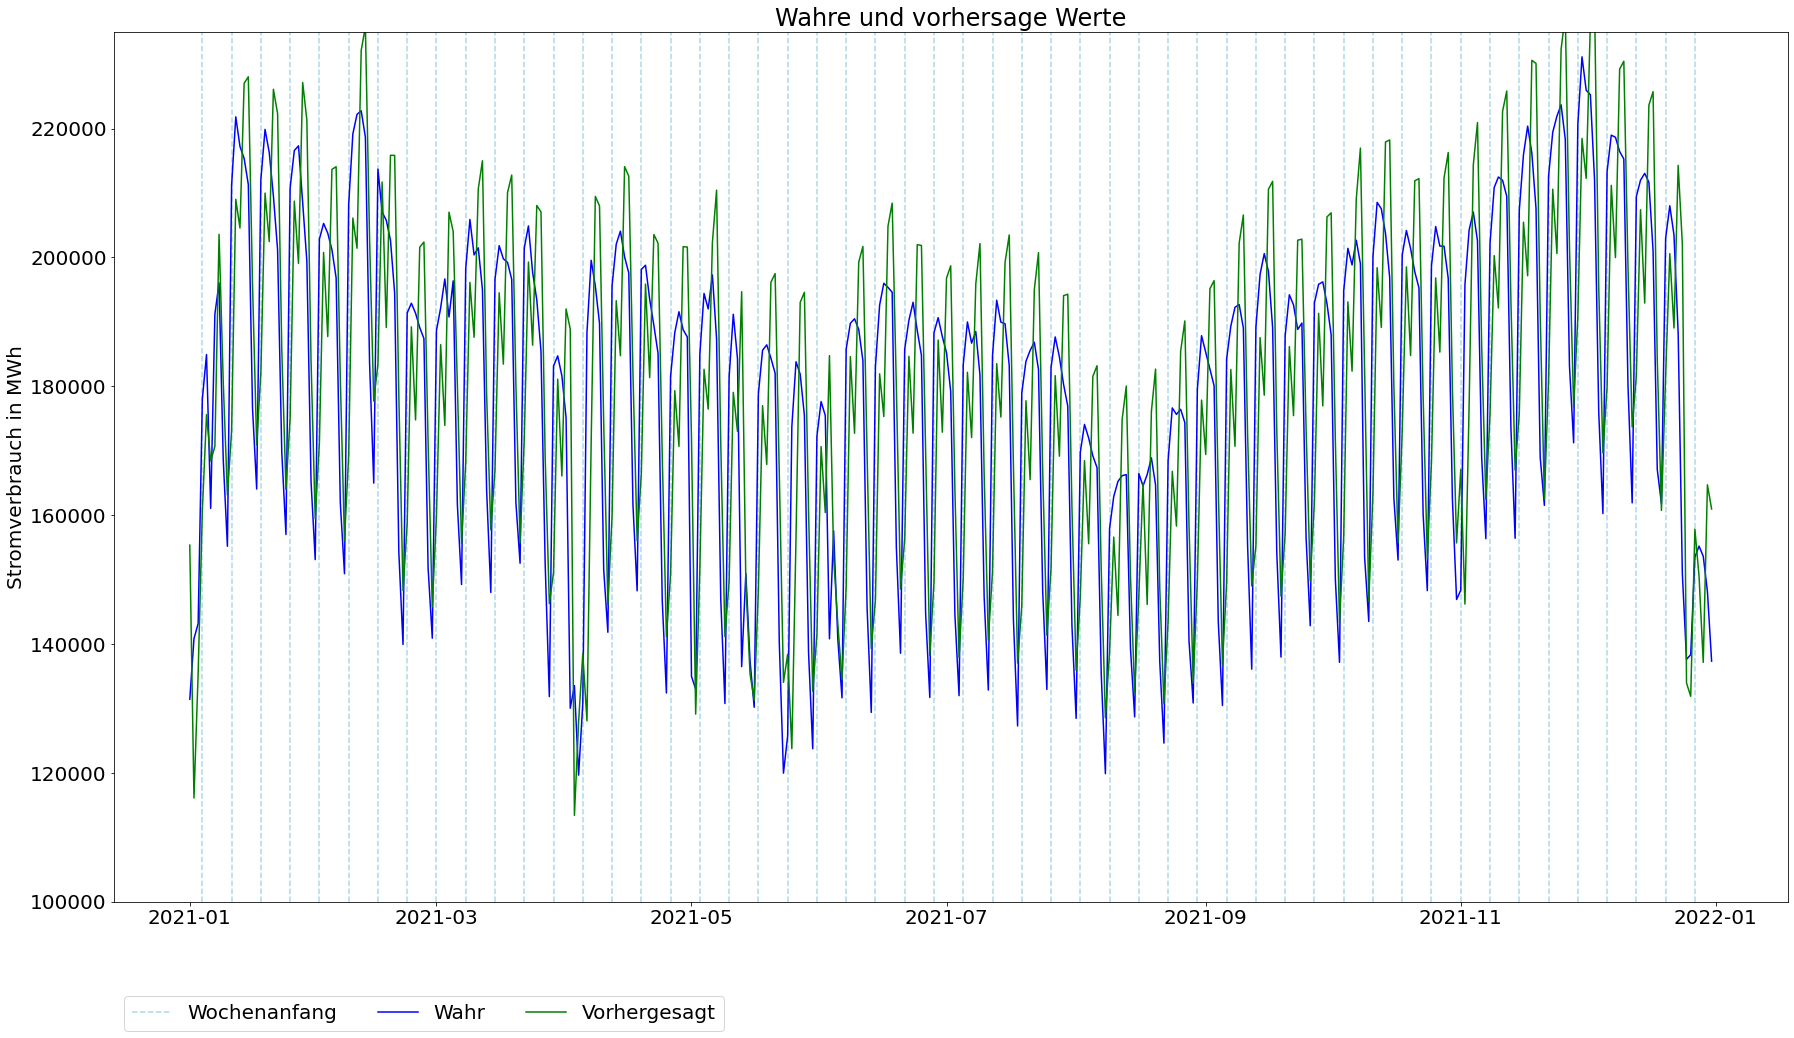

In [14]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(4,0,4)(4,0,4)7</font><a class="anchor" id="4-02a-ARIMA(4,0,4)(4,0,4)7"></a>

<font size="5">Wenn die vierten Ordnungen verwendet werden, handelt es sich bereits um ein sehr großes Modell mit 16 Koeffizienten. Ein derart umfangreiches Modell sollte eigentlich nicht verwendet werden, wird hier allerdings trotzdem betrachtet. Der MAPE fällt zwar auf 3,19%, da die Log-Likelihood mit 3.052 und das AIC mit -6.070 nur gering verbessert werden, ist hier von einer Überanpassung auszugehen. Dies wird auch durch die vielen, insignifikanten Lags deutlich.</font>

In [15]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (4, 0, 4) #p, d, q
seasonal_order = (4, 0, 4, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(4, 0, 4)x(4, 0, 4, 7)   Log Likelihood                3051.985
Date:                           Thu, 03 Feb 2022   AIC                          -6069.971
Time:                                   10:46:34   BIC                          -5970.579
Sample:                               01-01-2015   HQIC                         -6033.928
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1421      1.041      1.097      0.272      -0.898       3.182
ar.L2         -0.3893      0.923     -0.422

      Vorhersage
R2          0.89
MAE       5345.0
MSE   76339076.0
RMSE      8737.0
                
MAPE      3.19 %


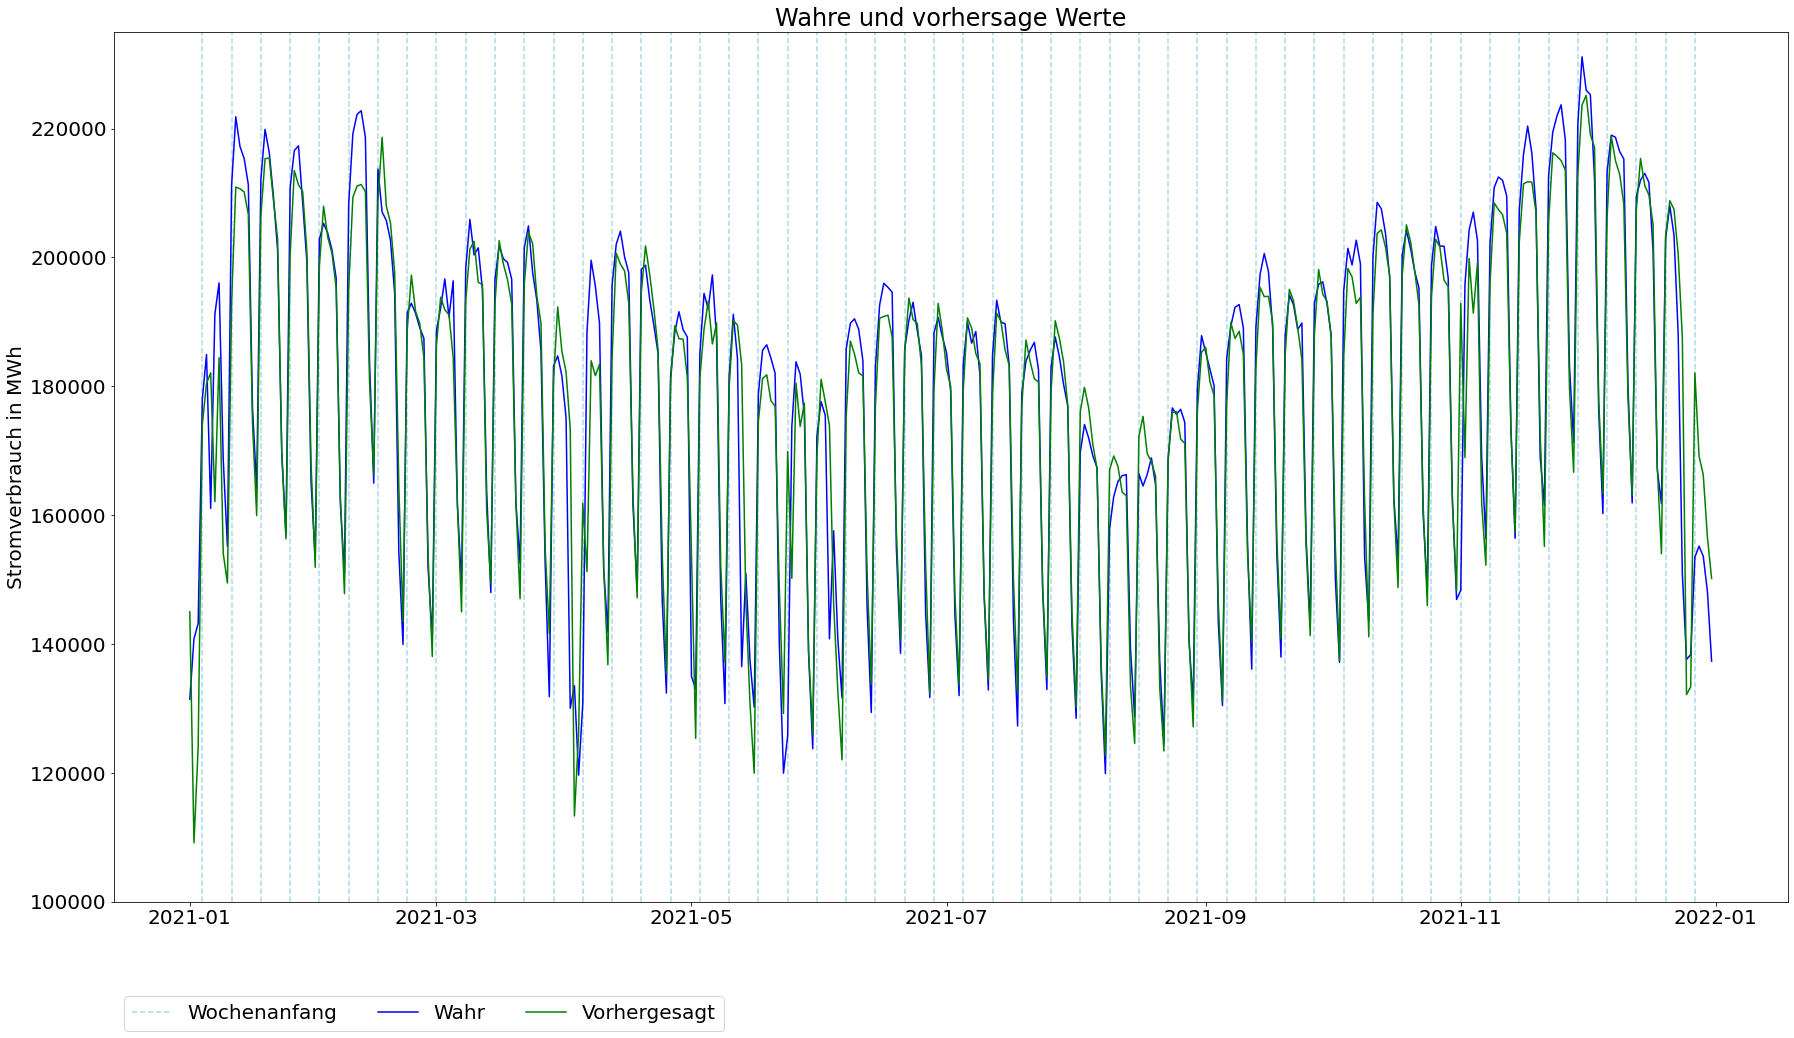

In [16]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA([1,2,6],0,2)(3,0,2)7</font><a class="anchor" id="4-02a-ARIMA([1,2,6],0,2)(3,0,2)7"></a>

<font size="5">Beim ARIMA([1,2,6],0,2)(3,0,2)7 werden nur die durch ACF/PACF als stark korrelierten Lags verwendet. Der MAPE ist mit 3,20% sehr ähnlich wie beim initialen Modell, auch Log-Likelihood ist sehr ähnlich. Das Modell verwendet allerdings zwei zusätzliche Lags, weshalb das AIC auf -6.048 ansteigt (-6.058 beim initialen Modell). Es ist hier also von einer Überanpassung auszugehen.</font>

In [17]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = ([1,2,6], 0, 2) #p, d, q
seasonal_order = (3, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                         SARIMAX Results                                         
Dep. Variable:                                 verbrauch   No. Observations:                 2557
Model:             SARIMAX([1, 2, 6], 0, 2)x(3, 0, 2, 7)   Log Likelihood                3034.997
Date:                                   Thu, 03 Feb 2022   AIC                          -6047.994
Time:                                           10:48:34   BIC                          -5983.682
Sample:                                       01-01-2015   HQIC                         -6024.672
                                            - 12-31-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5495      0.096      5.748      0.000    

      Vorhersage
R2          0.89
MAE       5352.0
MSE   77214864.0
RMSE      8787.0
                
MAPE       3.2 %


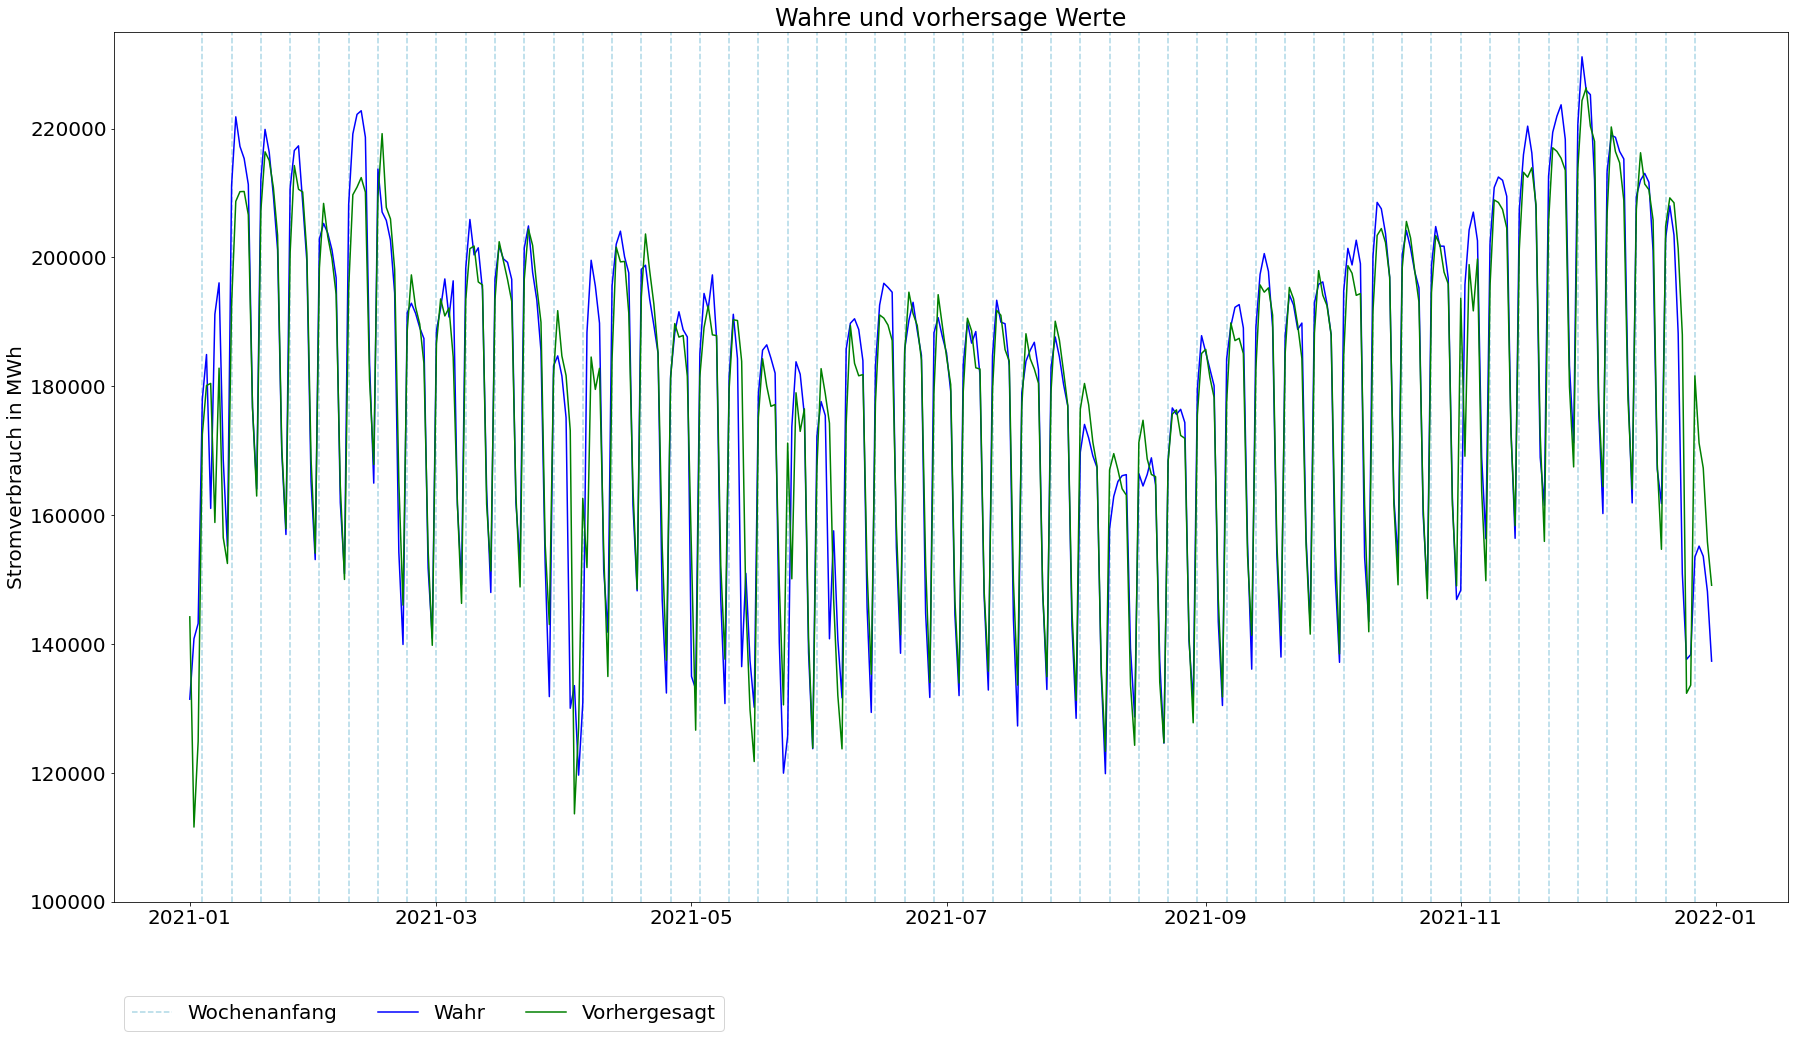

In [18]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(3,0,2)(2,0,2)7</font>

<font size="5"> Beim ARIMA(3,0,2)(2,0,2)7 wird ein größeres AR-Modul verwendet. Es zeigt sich ein ähnliches Verhalten wie beim ARIMA([1,2,6],0,2)(3,0,2)7, das Modell passt sich aufgrund der zusätzlichen Lags etwas stärker an die Trainingsdaten an, weshalb das AIC ansteigt. Gleichzeitig fällt die Güte des Modells aber ab. Es ist also auch hier von Überanpassungen auszugehen.<font>

In [19]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (3, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(3, 0, 2)x(2, 0, 2, 7)   Log Likelihood                3029.471
Date:                           Thu, 03 Feb 2022   AIC                          -6038.941
Time:                                   10:50:03   BIC                          -5980.475
Sample:                               01-01-2015   HQIC                         -6017.739
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4968      0.045     11.083      0.000       0.409       0.585
ar.L2          0.7728      0.059     13.089

      Vorhersage
R2          0.89
MAE       5388.0
MSE   77675555.0
RMSE      8813.0
                
MAPE      3.22 %


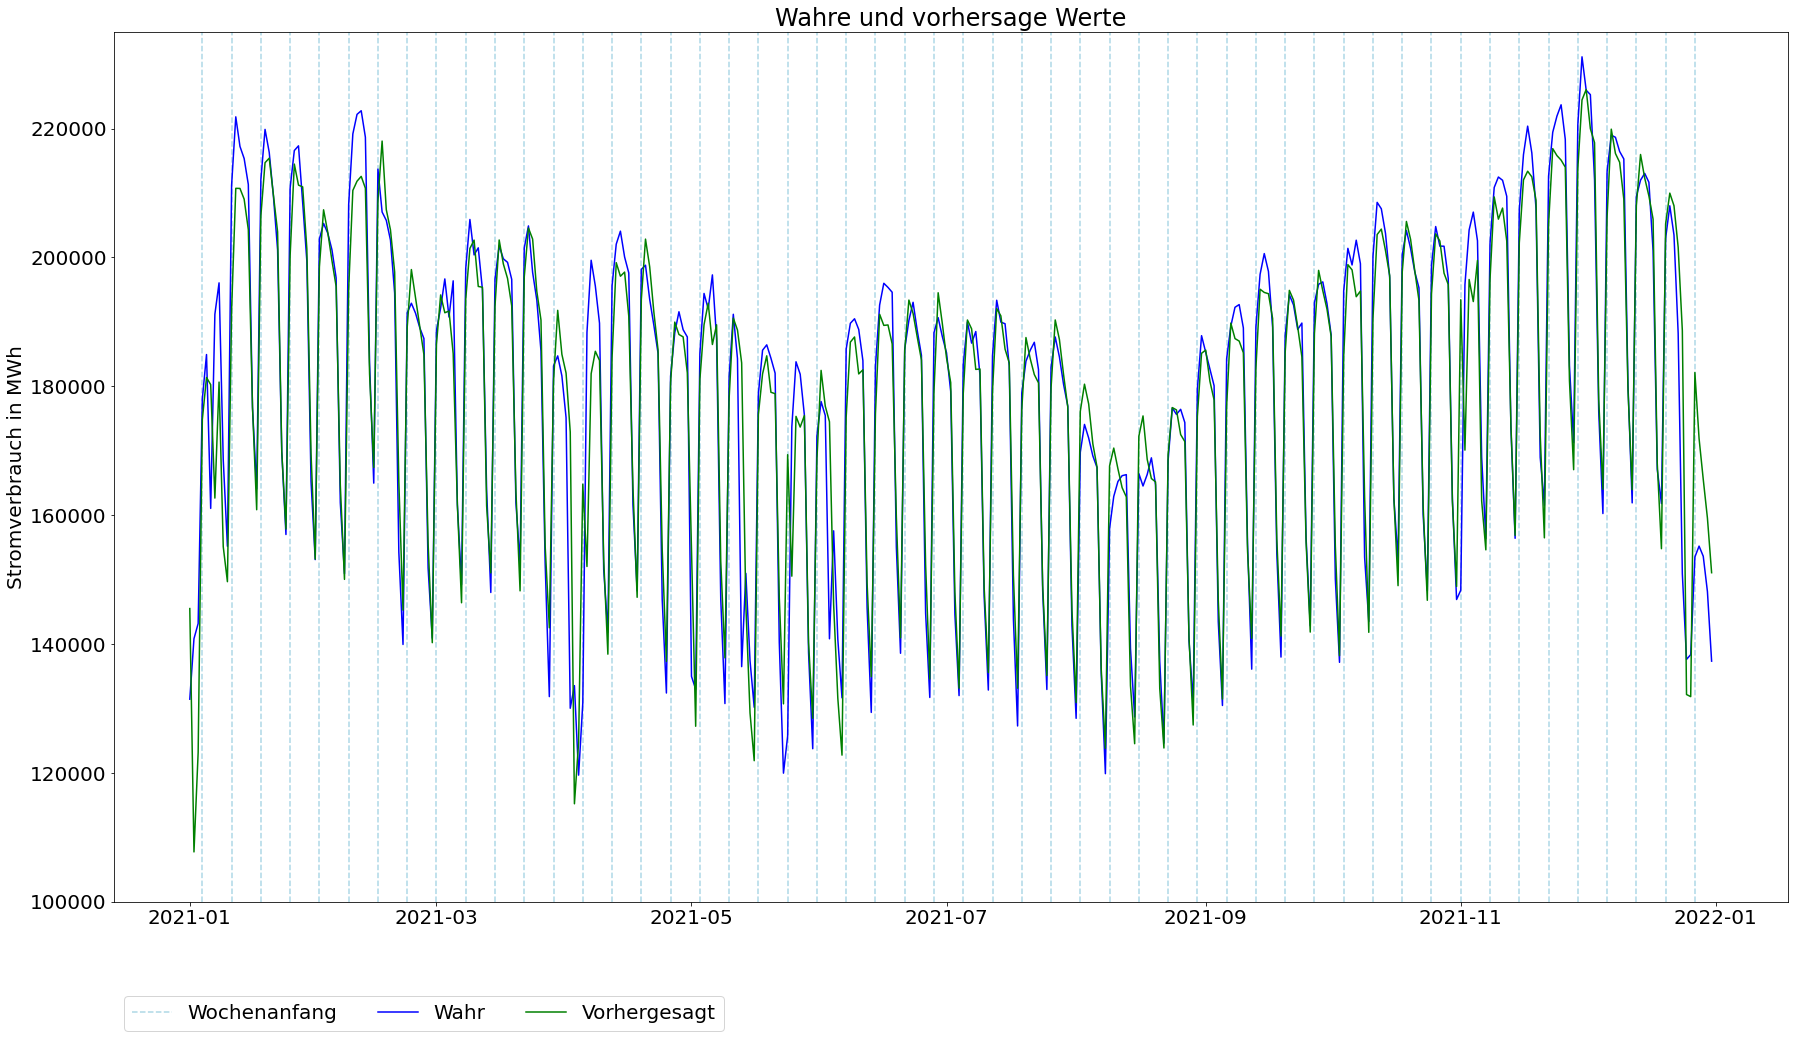

In [20]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA([1,2,4],0,2)(2,0,2)7</font><a class="anchor" id="4-02a-ARIMA([1,2,4],0,2)(2,0,2)7"></a>

<font size="5">Selbiges geschieht beim einem ARIMA([1,2,4],0,2)(2,0,2)7. Das Modell passt sich etwas besser an die Trainingsdaten an, erzielt sogar einen leicht besseren MAPE von 2,17%, allerdings steigt das AIC auf -6.043 an. ARIMA(2,0,2)(2,0,2)7 lässt sich also nicht durch zusätzliche Lags verbessern, ohne das Überanpassungen auftreten.<font>

In [21]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = ([1,2,4], 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                         SARIMAX Results                                         
Dep. Variable:                                 verbrauch   No. Observations:                 2557
Model:             SARIMAX([1, 2, 4], 0, 2)x(2, 0, 2, 7)   Log Likelihood                3031.378
Date:                                   Thu, 03 Feb 2022   AIC                          -6042.756
Time:                                           10:51:16   BIC                          -5984.290
Sample:                                       01-01-2015   HQIC                         -6021.555
                                            - 12-31-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4958      0.226      2.192      0.028    

      Vorhersage
R2          0.89
MAE       5325.0
MSE   76400831.0
RMSE      8741.0
                
MAPE      3.17 %


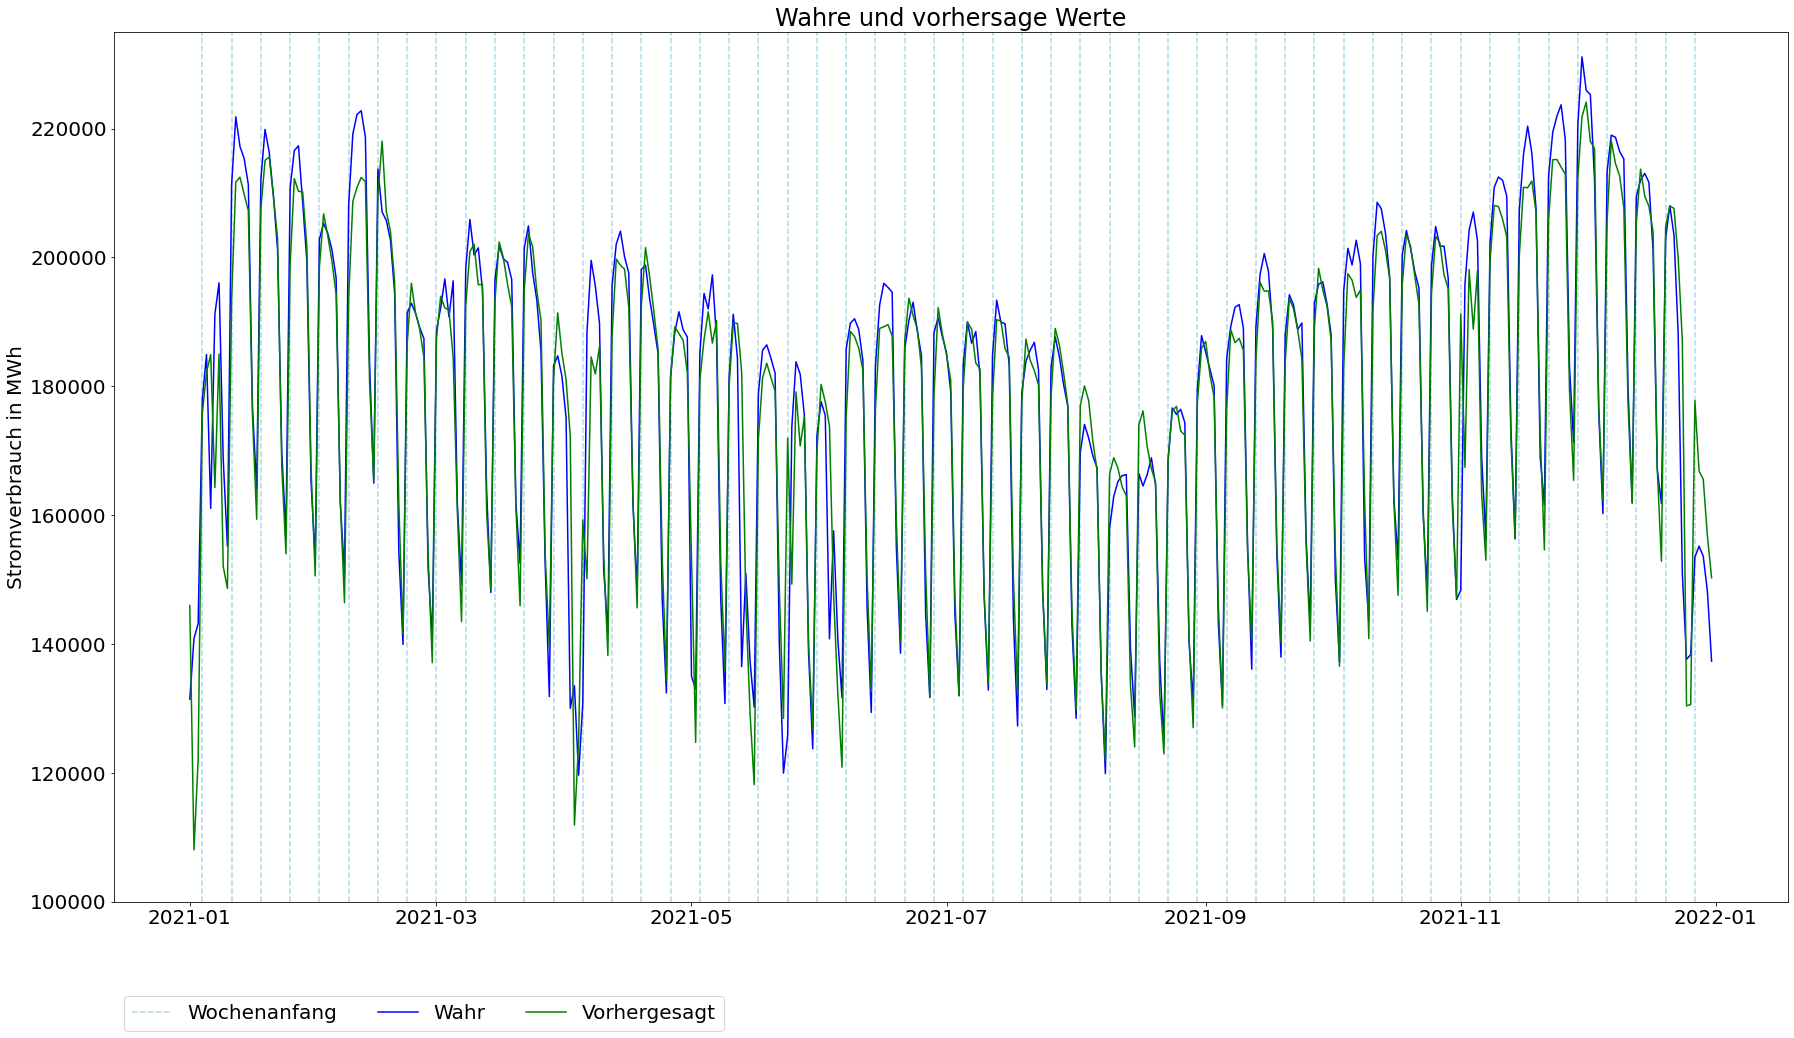

In [22]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

# <font size="7">Verbesserung durch weniger Lags</font>

<font size="5">Da sich ARIMA(2,0,2)(2,0,2)7 nicht durch weitere Lags verbessern lässt, wird nun versucht, ein gleichwertiges ARIMA-Modell mit weniger Lags zu erstellen.<font>

## <font size="6">ARIMA(1,0,1)(1,0,1)7</font><a class="anchor" id="4-02a-ARIMA(1,0,1)(1,0,1)7"></a>

<font size="5">Es wird zunächst versucht, alle Module auf die erste Ordnung zu verkleinern. Dadurch steigt der MAPE allerdings leicht auf 3,28% an. Gleichzeitig fällt Log-Likelihood auf 2.979 und das AIC steigt auf -5.947, es liegt also eine leichte Unteranpassung vor.<font>

In [23]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (1, 0, 1) #p, d, q
seasonal_order = (1, 0, 1, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                2978.545
Date:                           Thu, 03 Feb 2022   AIC                          -5947.089
Time:                                   10:56:42   BIC                          -5917.856
Sample:                               01-01-2015   HQIC                         -5936.489
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9000      0.009    101.035      0.000       0.883       0.917
ma.L1         -0.2587      0.014    -17.852

      Vorhersage
R2          0.89
MAE       5509.0
MSE   79731584.0
RMSE      8929.0
                
MAPE      3.28 %


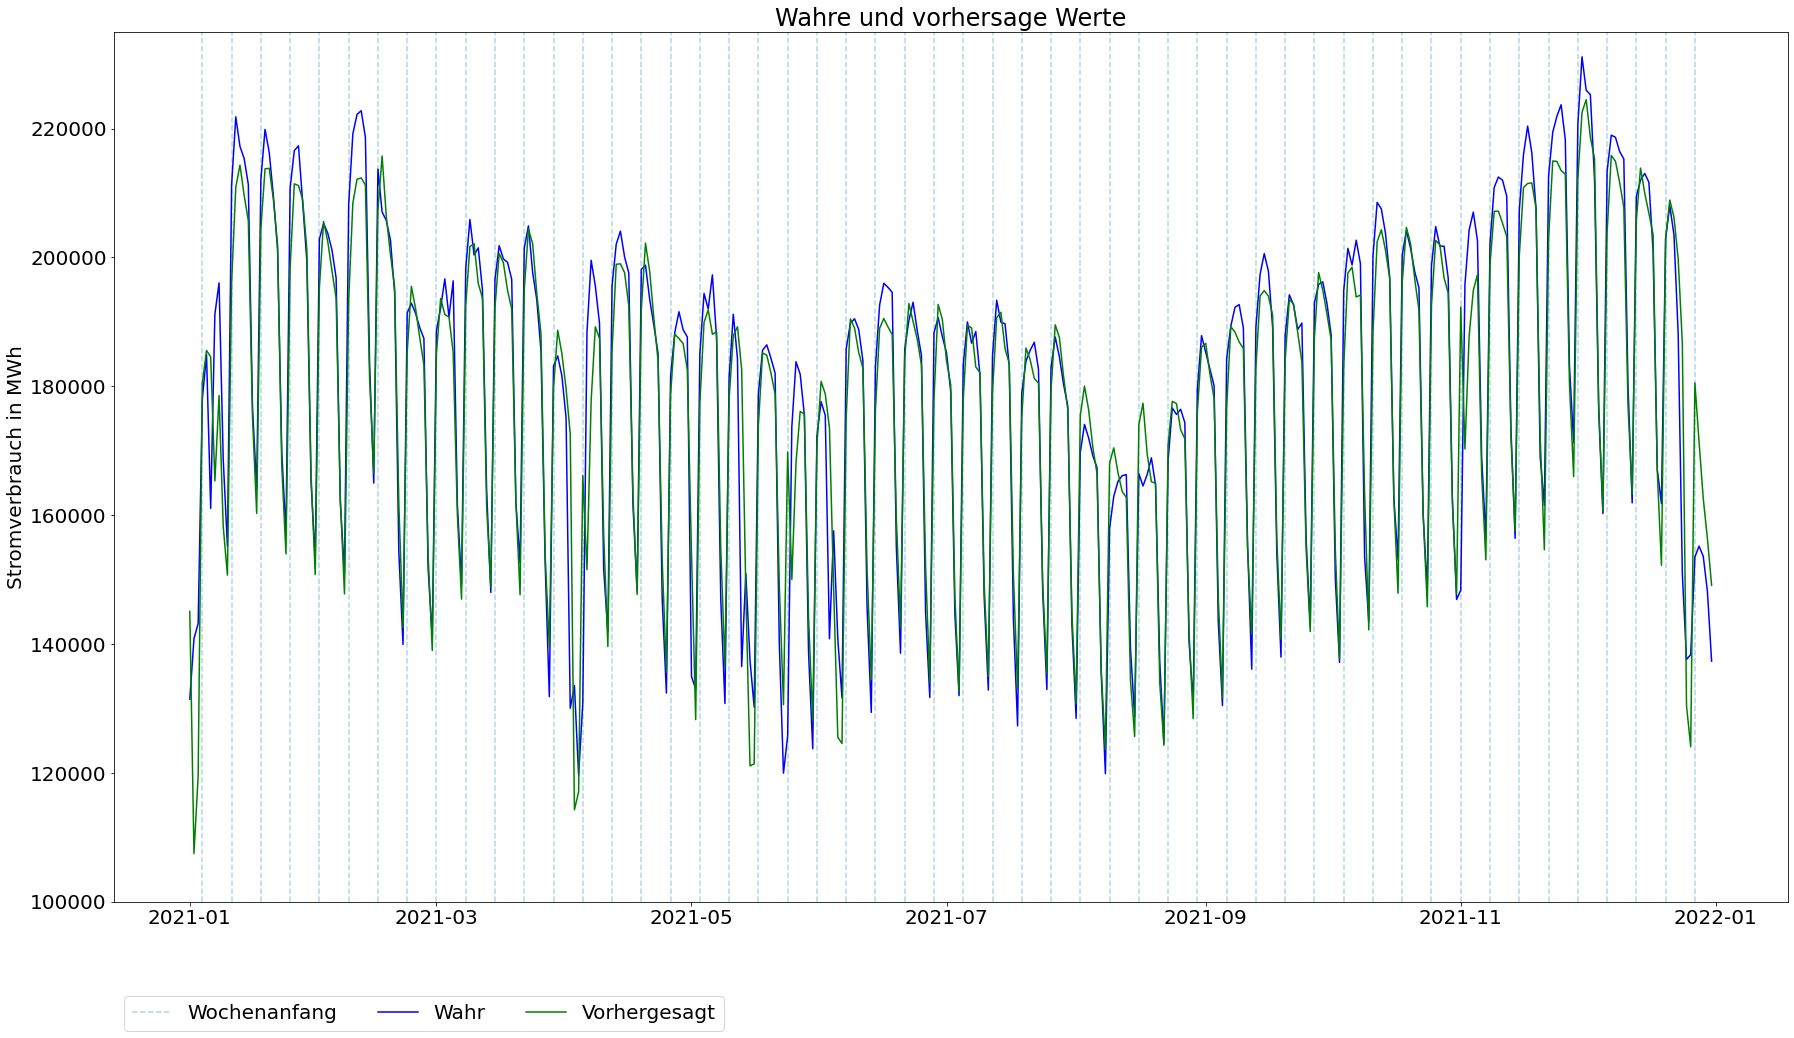

In [24]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(2,0,1)(2,0,1)7</font>

<font size="5">Wenn die MA- und SMA-Module verkleinert werden, führt dies ebenfalls zu einer Unteranpassung, da MAPE auf 3,32% und Log-Likelihood auf 2.956 fallen. Das AIC verschlechtert sich auf -5.898. Die höhere Abweichung ist also nicht durch die geringere Komplexität des Modells zu rechtfertigen.<font>

In [25]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 1) #p, d, q
seasonal_order = (2, 0, 1, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 7)   Log Likelihood                2955.786
Date:                           Thu, 03 Feb 2022   AIC                          -5897.572
Time:                                   10:57:53   BIC                          -5856.646
Sample:                               01-01-2015   HQIC                         -5882.731
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1886      0.028     -6.857      0.000      -0.243      -0.135
ar.L2          0.8071      0.023     34.718

      Vorhersage
R2          0.88
MAE       5618.0
MSE   82022843.0
RMSE      9057.0
                
MAPE      3.32 %


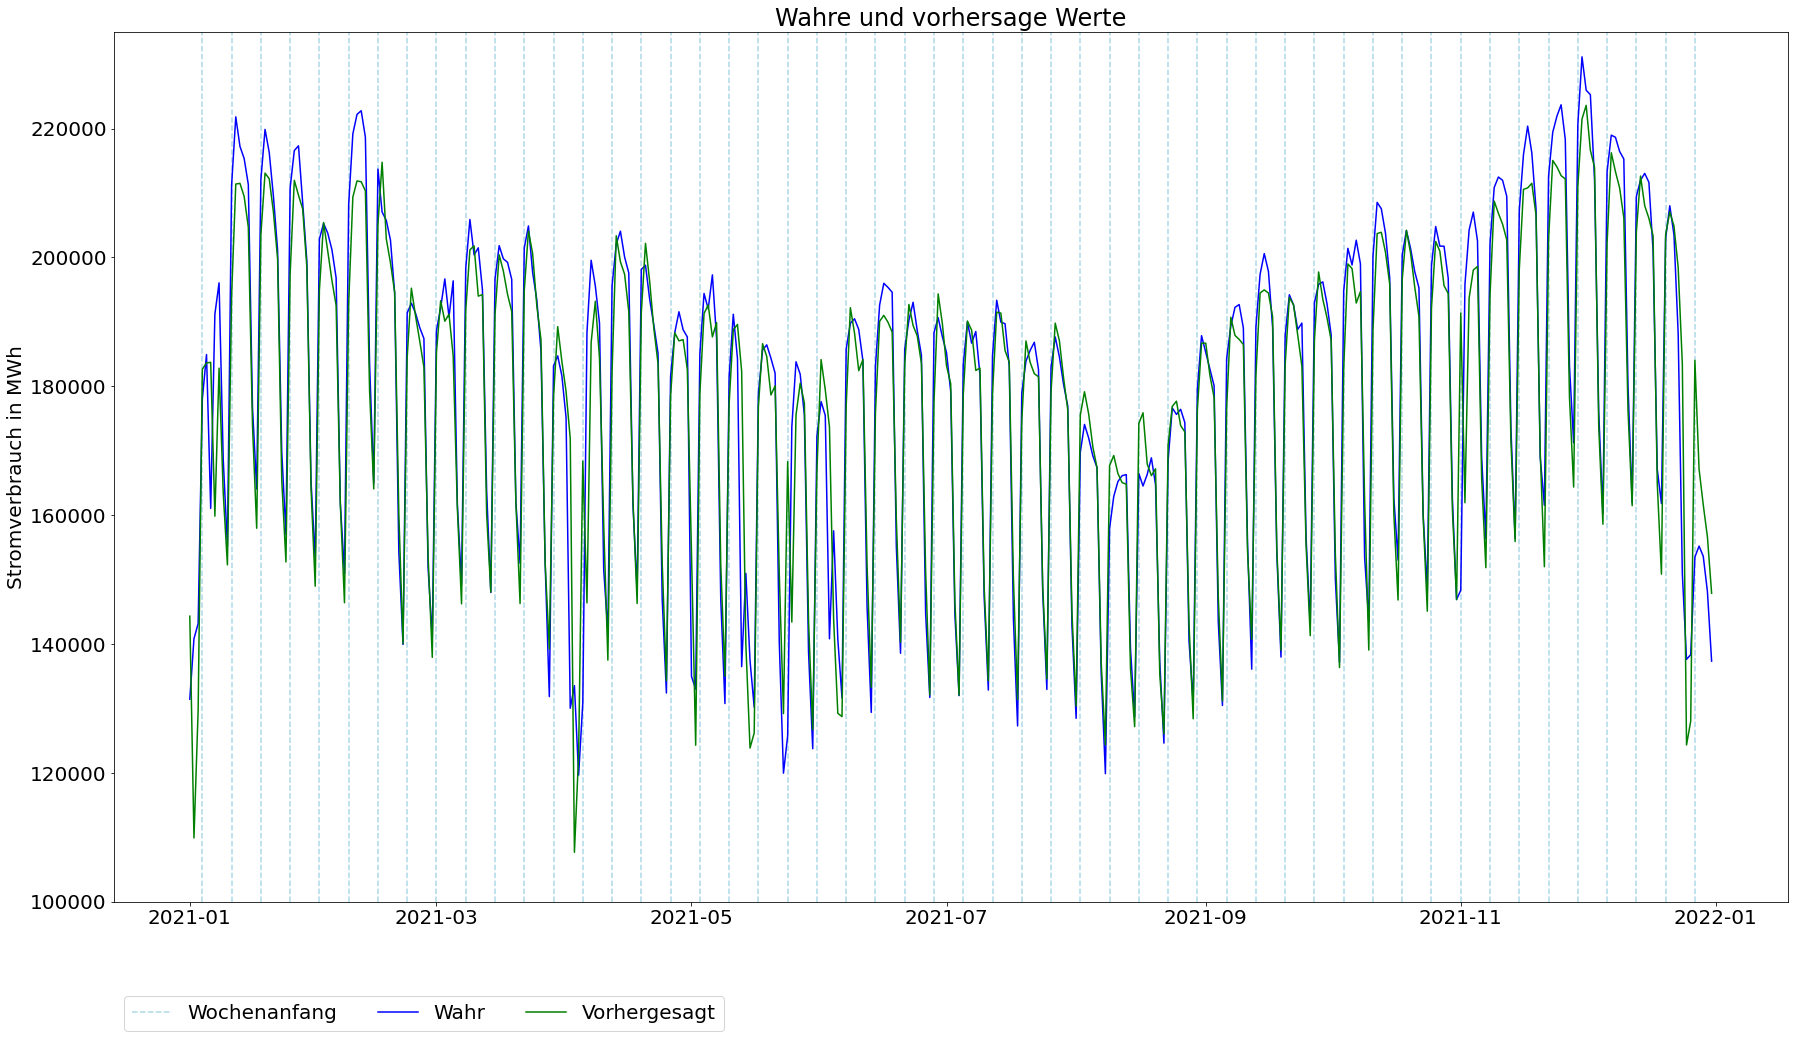

In [26]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(1,0,2)(1,0,2)7</font>

<font size="5">Das gleiche gilt, wenn die AR- und SAR-Module verkleinert werden. Es kommt ebenfalls zu einer Unteranpassung, da MAPE auf 3,34% und Log-Likelihood auf 2.981 fallen. Das AIC verschlechtert sich auf -5.949. Die höhere Abweichung ist also nicht durch die geringere Komplexität des Modells zu rechtfertigen.<font>

In [27]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (1, 0, 2) #p, d, q
seasonal_order = (1, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 7)   Log Likelihood                2981.889
Date:                           Thu, 03 Feb 2022   AIC                          -5949.778
Time:                                   10:59:48   BIC                          -5908.852
Sample:                               01-01-2015   HQIC                         -5934.937
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.000   3041.839      0.000       0.999       1.000
ma.L1         -0.2683      0.010    -26.584

      Vorhersage
R2          0.89
MAE       5547.0
MSE   79807735.0
RMSE      8934.0
                
MAPE      3.34 %


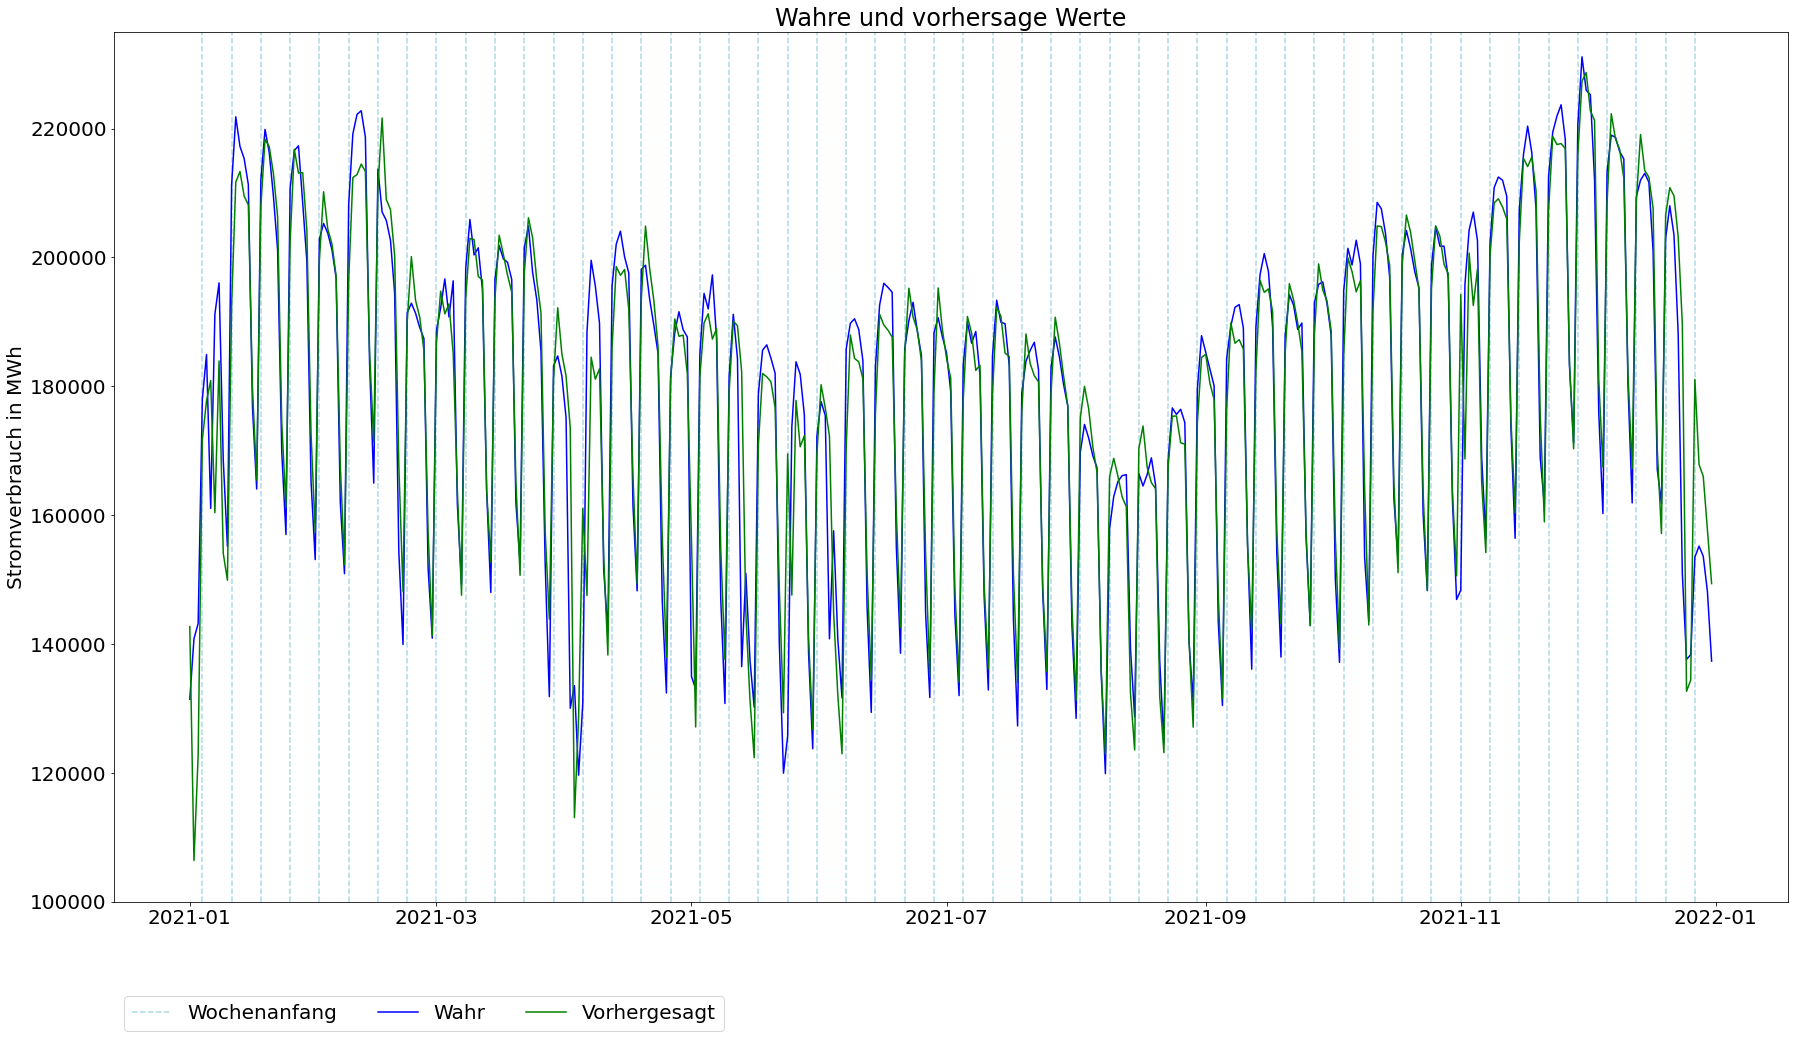

In [28]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(2,0,0)(2,0,0)7</font>

<font size="5">Wenn die MA- und SMA-Module deaktiviert werden, führt dies zu einer stärkeren Verschlechterung. Der MAPE steigt auf 3,82%. Die Log-Likelihood fällt sehr stark auf 2.599 ab, dementsprechend steigt auch das AIC auf -5.188 an. Es handelt sich hier also um eine sehr starke Unteranpassung.<font>

In [29]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 0) #p, d, q
seasonal_order = (2, 0, 0, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood                2598.973
Date:                           Thu, 03 Feb 2022   AIC                          -5187.946
Time:                                   11:00:46   BIC                          -5158.713
Sample:                               01-01-2015   HQIC                         -5177.345
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6850      0.012     55.839      0.000       0.661       0.709
ar.L2          0.0320      0.016      1.982

       Vorhersage
R2           0.84
MAE        6571.0
MSE   114039493.0
RMSE      10679.0
                 
MAPE       3.82 %


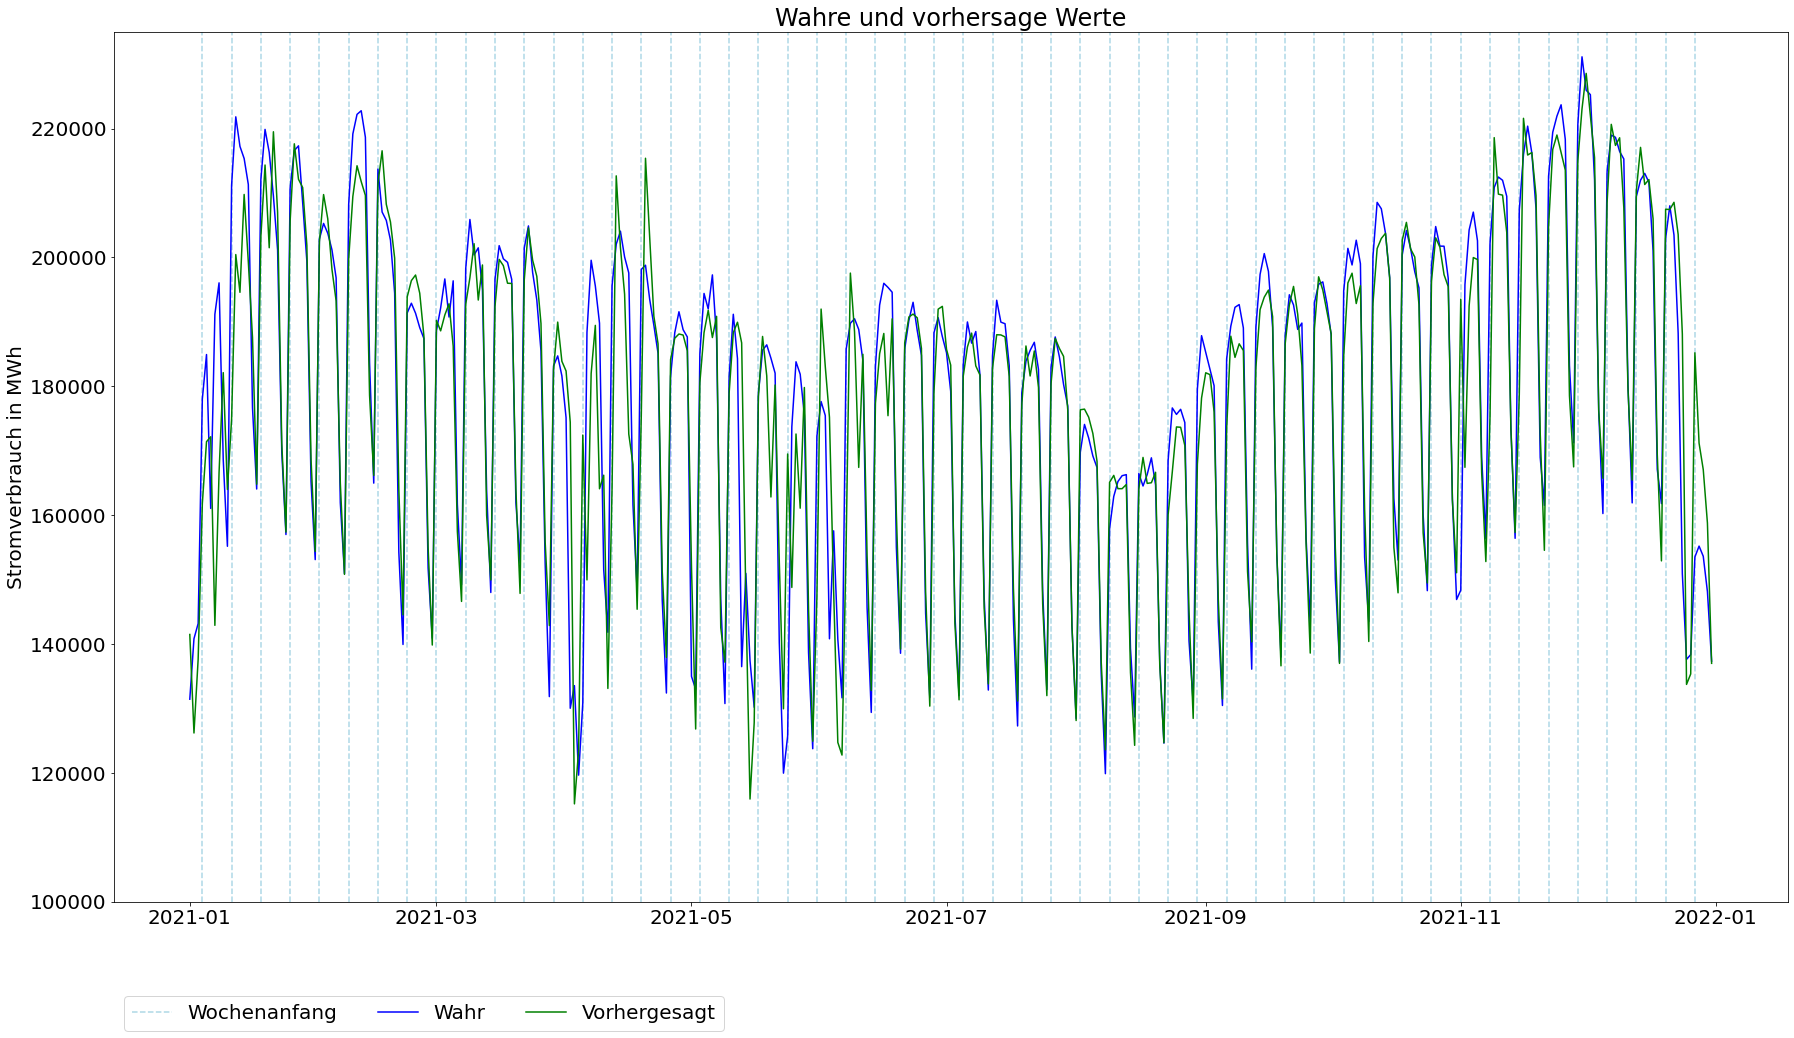

In [30]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(0,0,2)(0,0,2)7</font><a class="anchor" id="4-02a-ARIMA(0,0,2)(0,0,2)7"></a>

<font size="5">Dieses Verhalten zeigt sich bei der Deaktivierung der AR- und SAR-Module noch viel deutlicher. Der MAPE schießt auf 8,94% in die Höhe. Die Log-Likelihood fällt auf 1.149 und dementsprechend steigt das AIC auf -2.289 an. Es handelt sich hier also um eine sehr starke Unteranpassung.<font>

In [31]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (0, 0, 2) #p, d, q
seasonal_order = (0, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(0, 0, 2)x(0, 0, 2, 7)   Log Likelihood                1147.878
Date:                           Thu, 03 Feb 2022   AIC                          -2285.756
Time:                                   11:01:57   BIC                          -2256.523
Sample:                               01-01-2015   HQIC                         -2275.156
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9766      0.016     60.978      0.000       0.945       1.008
ma.L2          0.3793      0.018     21.181

       Vorhersage
R2           0.41
MAE       16291.0
MSE   412332149.0
RMSE      20306.0
                 
MAPE       8.94 %


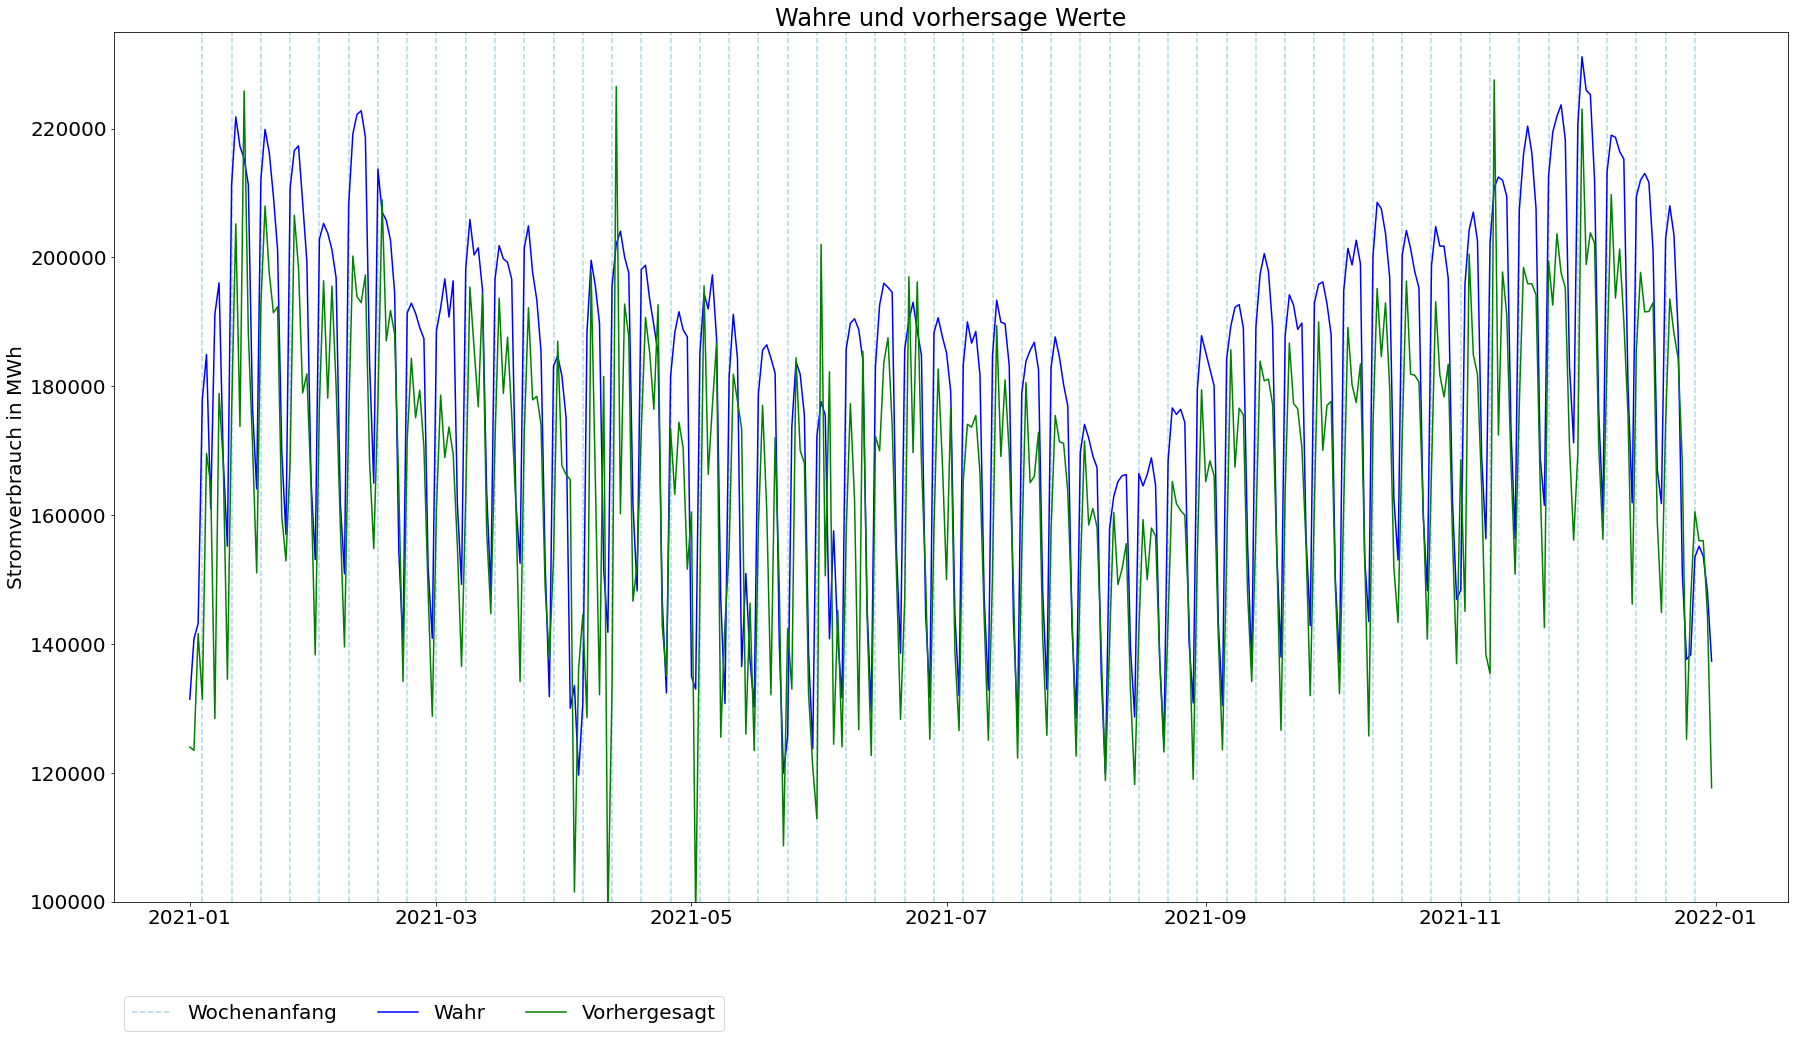

In [32]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(0,0,0)(2,0,2)7</font><a class="anchor" id="4-02a-ARIMA(0,0,0)(2,0,2)7"></a>

<font size="5">Wenn die nicht-saisonalen Module deaktiviert werden, tritt ebenfalls eine Unteranpassung auf, allerdings ist sie weniger stark ausgeprägt. Der MAPE steigt dennoch auf 6,02%. Die Log-Likelihood fällt auf 1.965, das AIC steigt auf -3.920 an.<font>

In [38]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (0, 0, 0) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                  SARIMAX Results                                   
Dep. Variable:                    verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, [1, 2], 7)   Log Likelihood                1965.244
Date:                      Thu, 03 Feb 2022   AIC                          -3920.488
Time:                              11:05:55   BIC                          -3891.255
Sample:                          01-01-2015   HQIC                         -3909.887
                               - 12-31-2021                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.6491      0.016    105.378      0.000       1.618       1.680
ar.S.L14      -0.6491      0.016    -41.481      0.000      -0.680      -0.618
ma.S

       Vorhersage
R2           0.69
MAE       10574.0
MSE   216492579.0
RMSE      14714.0
                 
MAPE       6.02 %


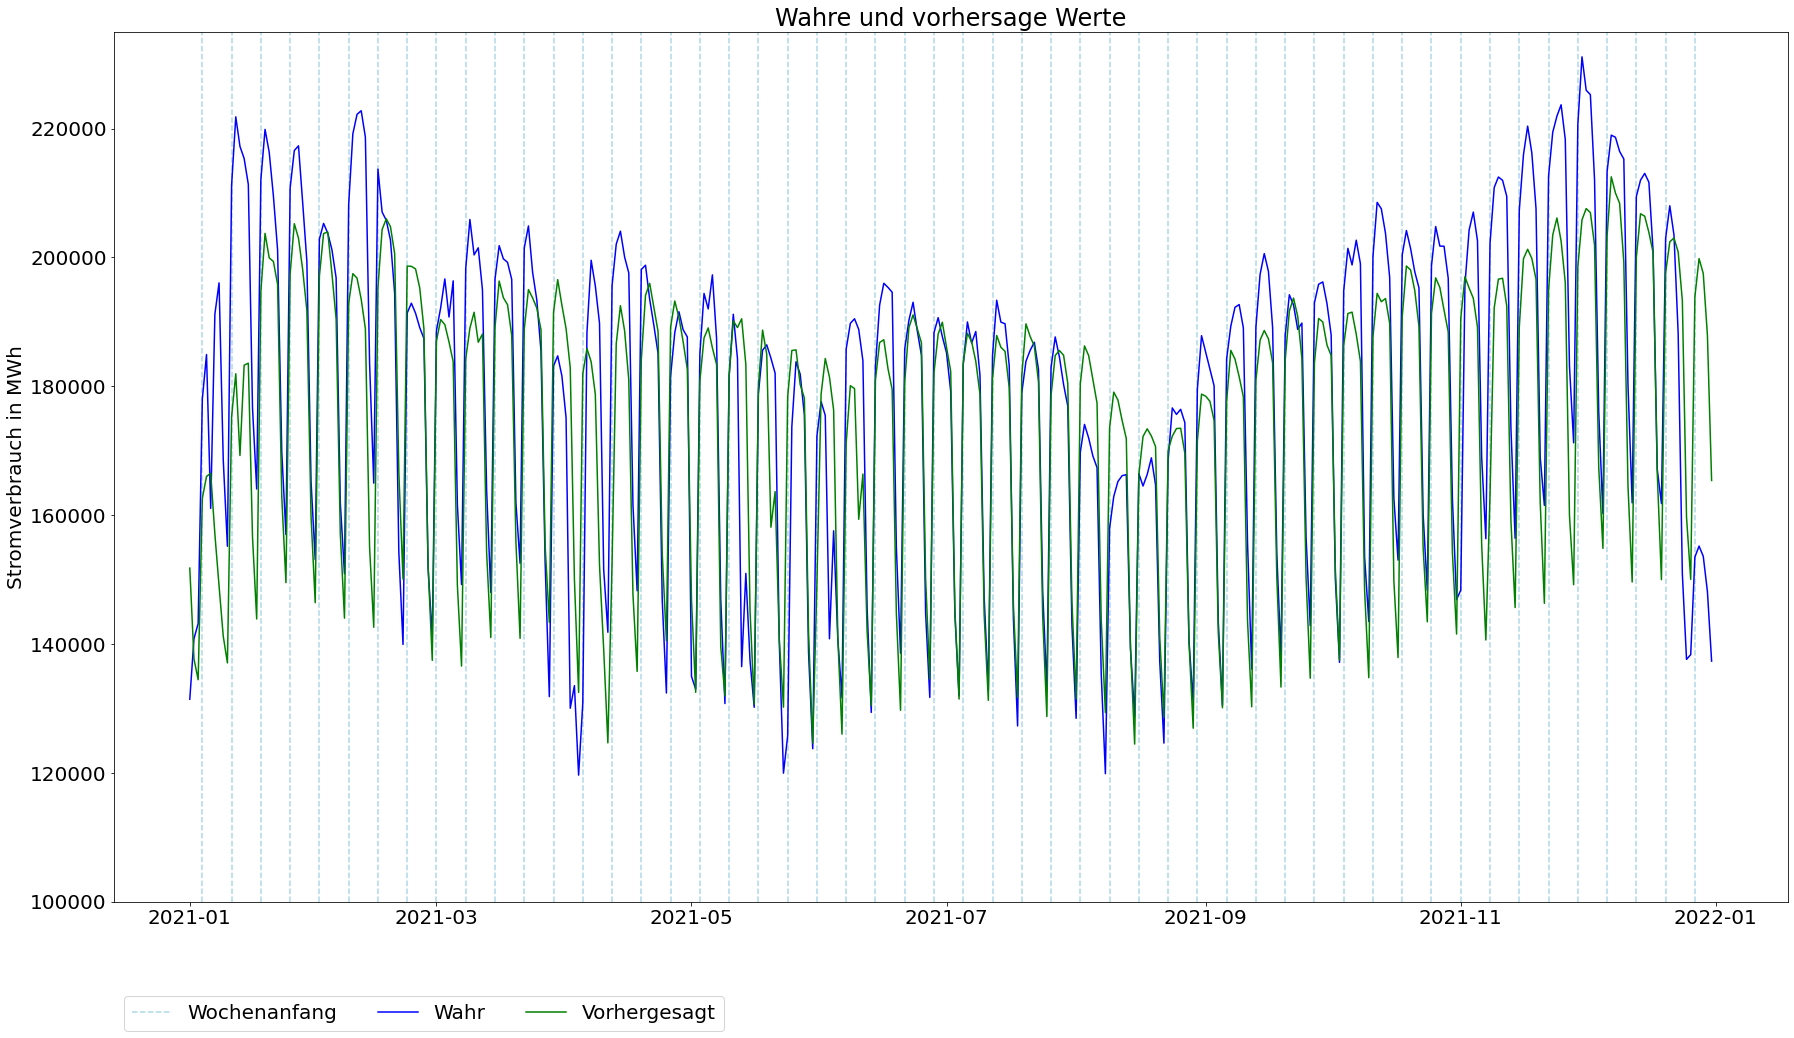

In [39]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(0,0,0)(2,0,1)7</font>

<font size="5">Die auto_arima()-Funktion ermittelt mit einem ARIMA(0,0,0)(2,0,1)7 ein sehr ähnliches Modell, auch hier ist die deutliche Unteranpassung sofort ersichtlich.<font>

In [33]:
model = auto_arima(y=endog, seasonal=True, m=7, d=0, D=0, start_p=0, start_q=0, max_p=0, max_q=0, information_criterion="aic", trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-3746.123, Time=1.85 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-705.558, Time=0.18 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-3630.295, Time=0.99 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-2285.170, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=4297.801, Time=0.09 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-3905.417, Time=4.30 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-3699.382, Time=2.42 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=-3892.243, Time=5.33 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-3864.293, Time=4.48 sec
 ARIMA(0,0,0)(2,0,1)[7]             : AIC=inf, Time=2.64 sec

Best model:  ARIMA(0,0,0)(2,0,1)[7] intercept
Total fit time: 22.787 seconds


In [36]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (0, 0, 0) #p, d, q
seasonal_order = (2, 0, 1, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                 SARIMAX Results                                 
Dep. Variable:                 verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, [1], 7)   Log Likelihood                1960.965
Date:                   Thu, 03 Feb 2022   AIC                          -3913.930
Time:                           11:04:41   BIC                          -3890.543
Sample:                       01-01-2015   HQIC                         -3905.449
                            - 12-31-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.5712      0.013    122.982      0.000       1.546       1.596
ar.S.L14      -0.5712      0.013    -44.717      0.000      -0.596      -0.546
ma.S.L7       -0.9917      0

       Vorhersage
R2           0.69
MAE       10665.0
MSE   216783655.0
RMSE      14724.0
                 
MAPE       6.06 %


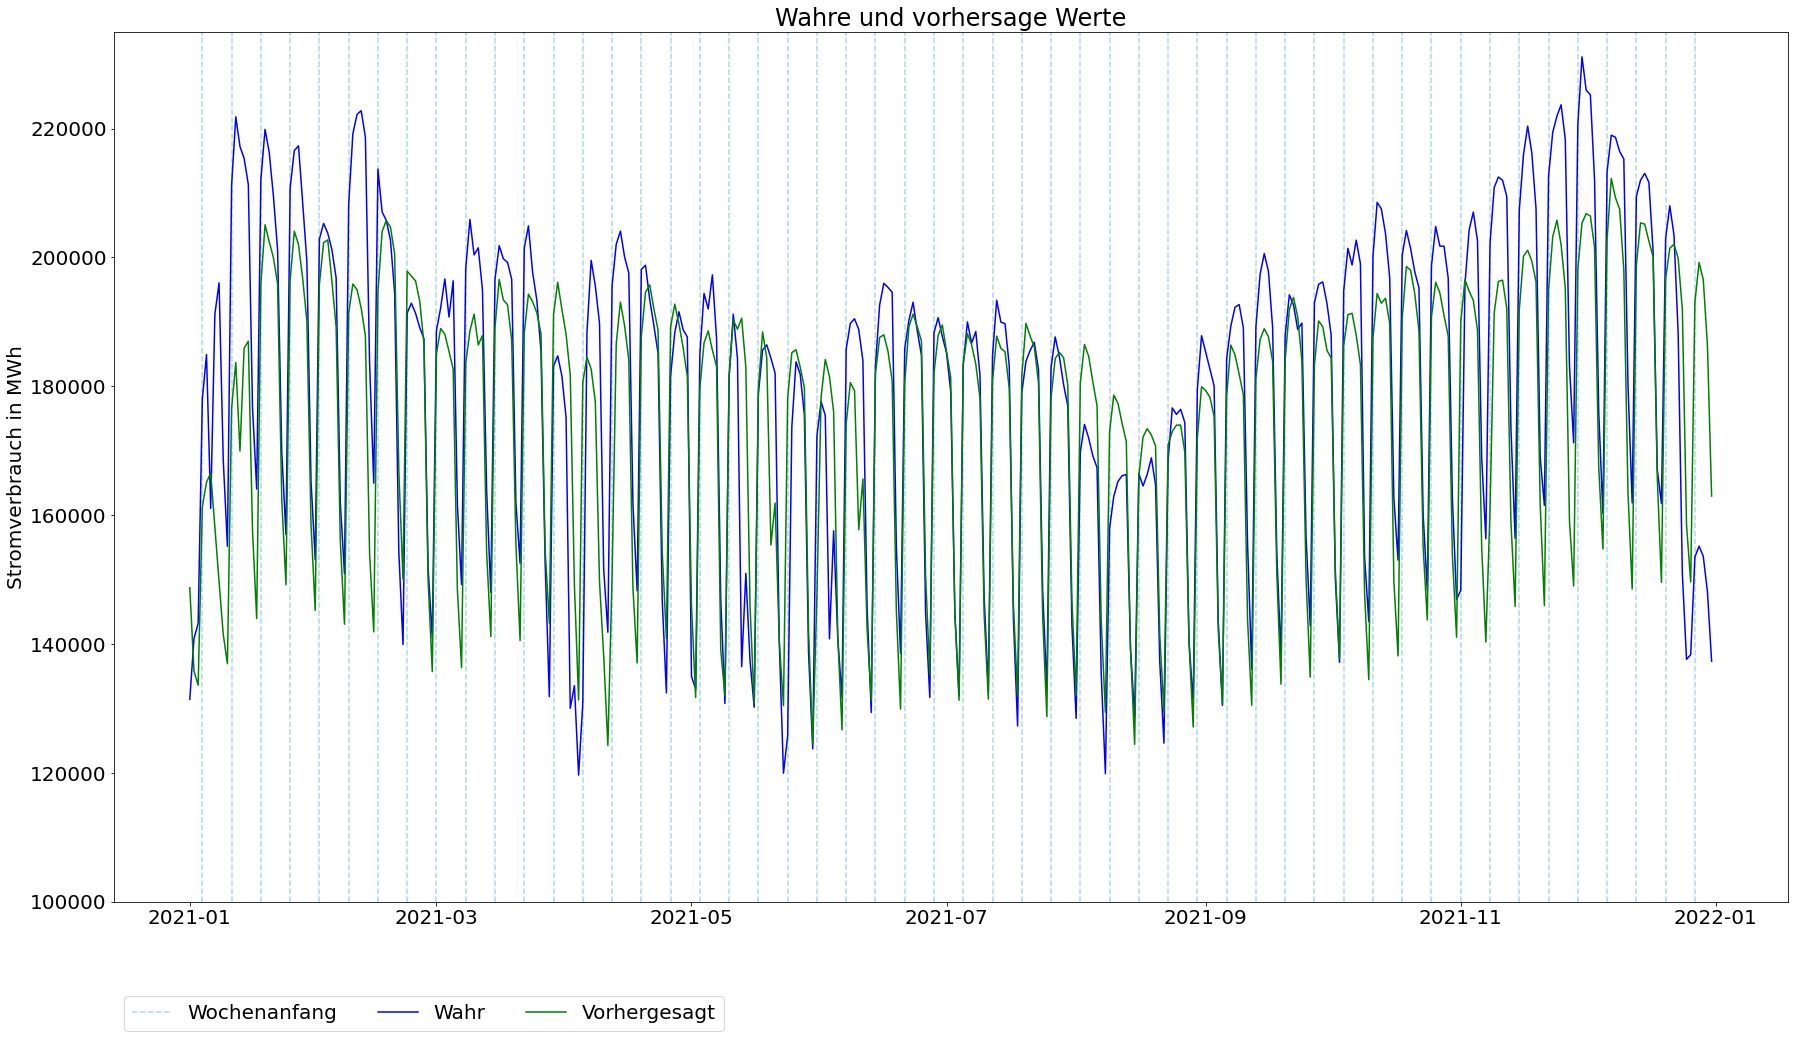

In [37]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(2,0,2)(0,0,0)7</font>

<font size="5">Wenn die saisonalen Module abgeschaltet werden, führt dies zu einer sehr starken Unteranpassung. Der MAPE steigt auf 9,5% an, im Plot ist erkennbar, dass die wöchentliche Saisonalität nur noch schwer erkannt werden kann. Die Log-Likelihood erreicht mit 1.100 einen Tiefststand, das AIC ist mit -2.190 so hoch wie bei keinem anderen Modell.<font>

In [41]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (0, 0, 0, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                               SARIMAX Results                                
Dep. Variable:              verbrauch   No. Observations:                 2557
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1100.057
Date:                Thu, 03 Feb 2022   AIC                          -2190.114
Time:                        11:10:40   BIC                          -2160.881
Sample:                    01-01-2015   HQIC                         -2179.513
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9384      0.036     25.749      0.000       0.867       1.010
ar.L2          0.0612      0.036      1.691      0.091      -0.010       0.132
ma.L1         -0.1639      0.019     -8.543      0.0

       Vorhersage
R2           0.46
MAE       16073.0
MSE   379065569.0
RMSE      19470.0
                 
MAPE        9.5 %


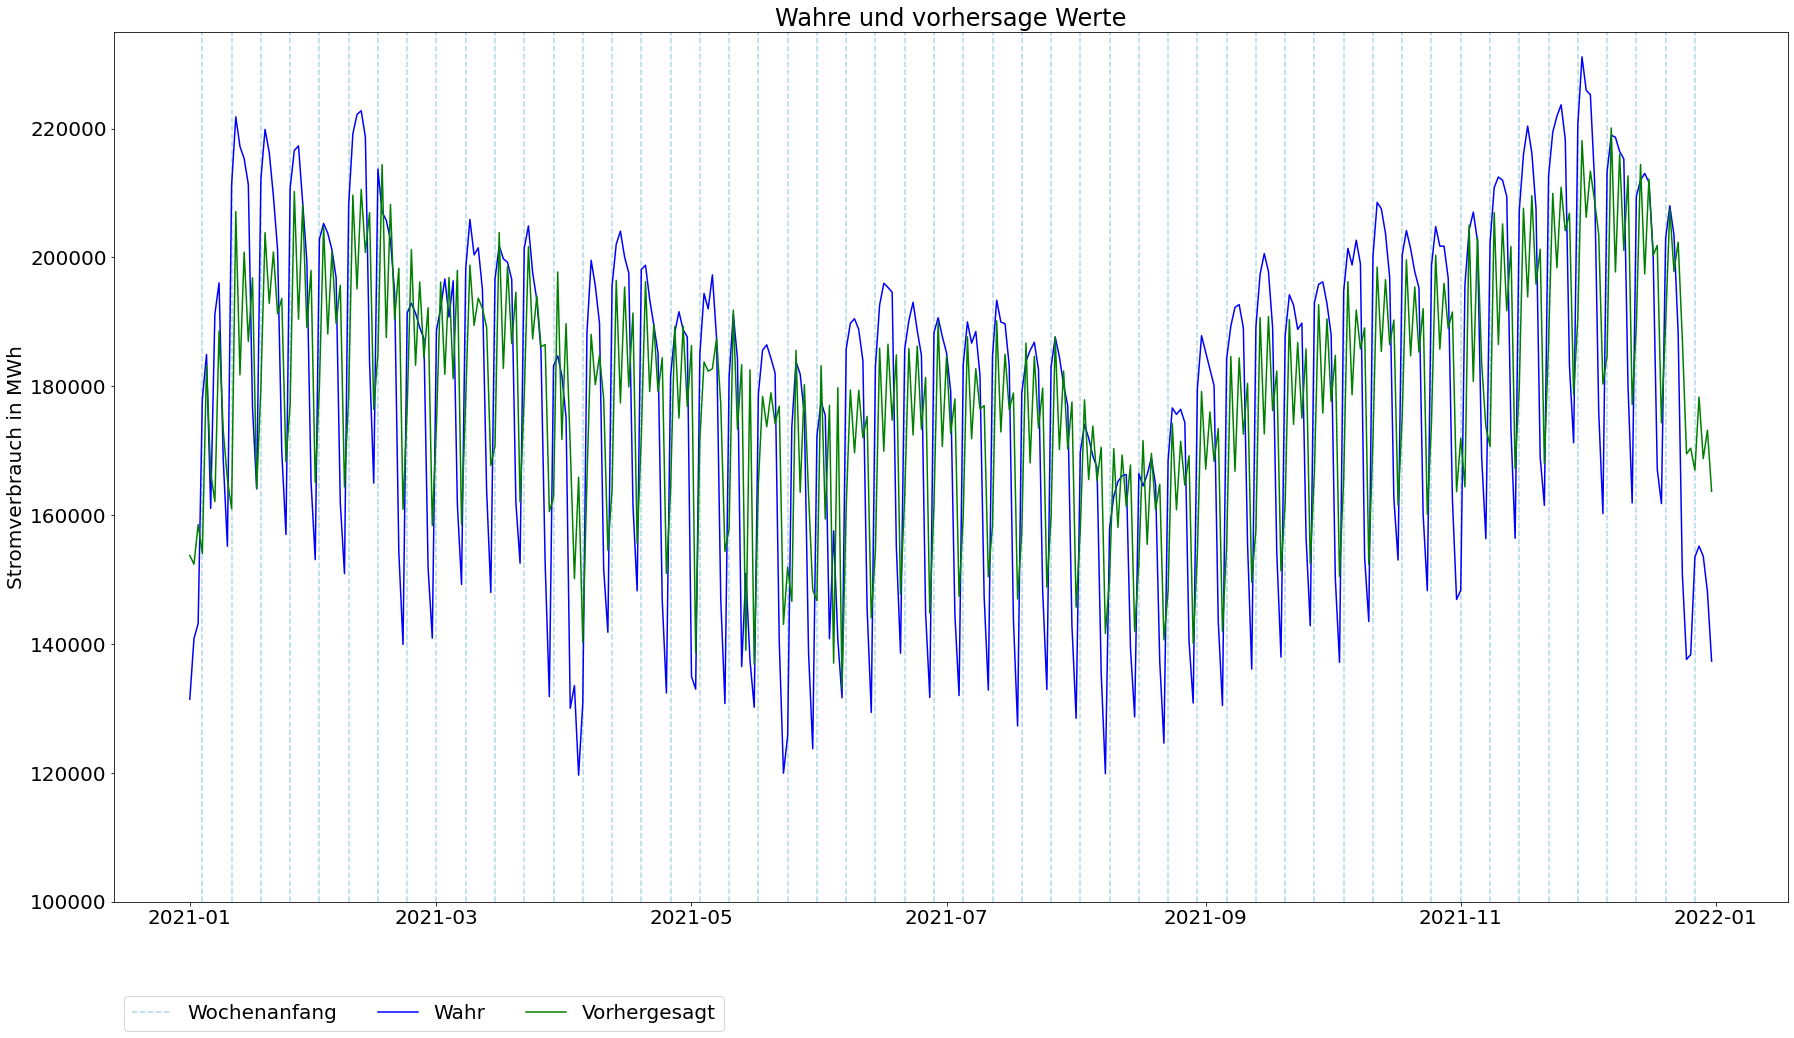

In [42]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(2,0,5)(0,0,0)7</font><a class="anchor" id="4-02a-ARIMA(2,0,5)(0,0,0)7"></a>

<font size="5">Die auto_arima()-Funktion ermittelt mit ARIMA(2,0,5)(0,0,0)7 ein etwas umfangreicheres Modell, welches leicht besser ist als das ARIMA(2,0,2)(0,0,0)7. Allerdings liegt hier immer noch eine sehr starke Unteranpassung vor.<font>

In [43]:
model = auto_arima(y=endog, seasonal=False, d=0, information_criterion="aic", trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2190.603, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4297.801, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1190.569, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1413.651, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2190.828, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=120.292, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1233.988, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-2190.396, Time=0.89 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-196.997, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1449.273, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-2219.065, Time=1.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.73 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-2396.594, Time=1.41 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-2336.809, Time=1.12 sec
 ARIMA(3,0,4)(0,0,0)[0]       

In [44]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 5) #p, d, q
seasonal_order = (0, 0, 0, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                               SARIMAX Results                                
Dep. Variable:              verbrauch   No. Observations:                 2557
Model:               SARIMAX(2, 0, 5)   Log Likelihood                1357.619
Date:                Thu, 03 Feb 2022   AIC                          -2699.238
Time:                        11:12:31   BIC                          -2652.465
Sample:                    01-01-2015   HQIC                         -2682.276
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5017      0.036     13.914      0.000       0.431       0.572
ar.L2          0.4912      0.036     13.670      0.000       0.421       0.562
ma.L1          0.3121      0.029     10.832      0.0

       Vorhersage
R2           0.55
MAE       14806.0
MSE   310385489.0
RMSE      17618.0
                 
MAPE       8.59 %


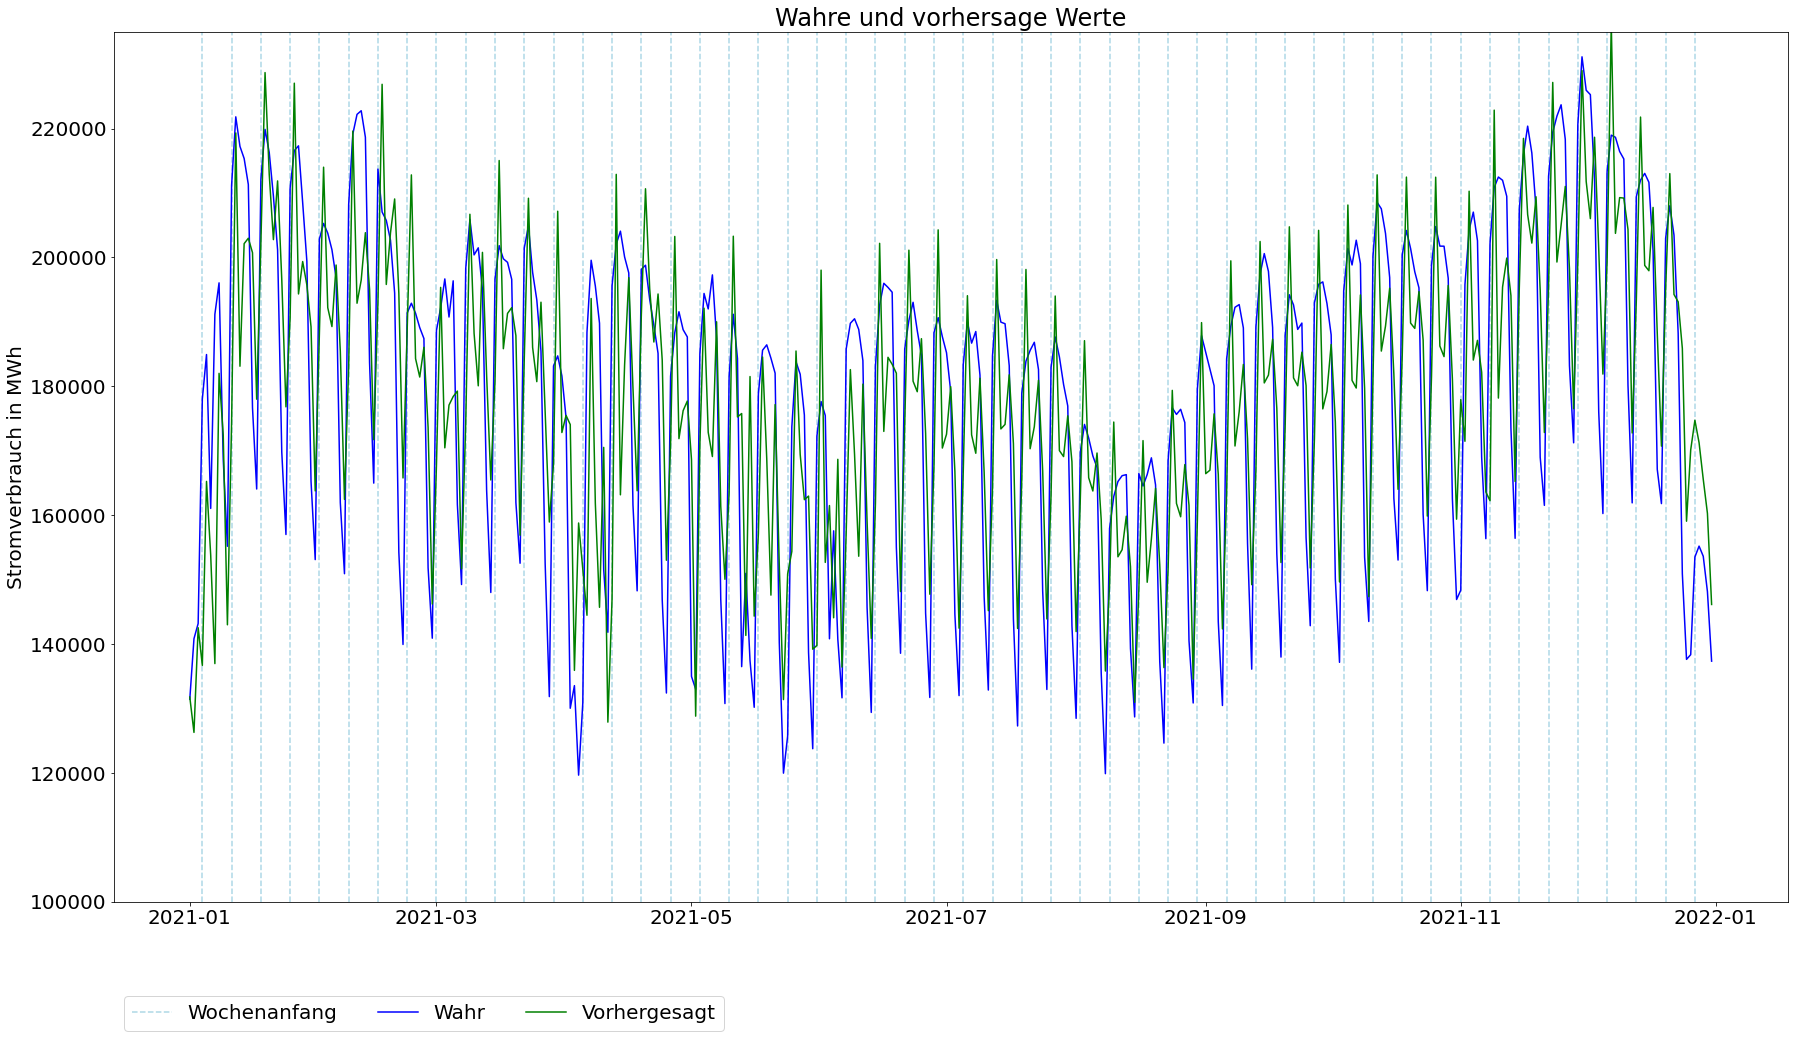

In [45]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

## <font size="6">ARIMA(4,0,2)(0,0,0)7</font>

<font size="5">Beim ARIMA(4,0,2)(0,0,0)7 werden mehr signifikante Lags in das AR-Modul einbezogen, allerdings zeigt sich auch hier eine starke Unteranpassung.<font>

In [46]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (4, 0, 2) #p, d, q
seasonal_order = (0, 0, 0, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                               SARIMAX Results                                
Dep. Variable:              verbrauch   No. Observations:                 2557
Model:               SARIMAX(4, 0, 2)   Log Likelihood                1138.758
Date:                Thu, 03 Feb 2022   AIC                          -2263.515
Time:                        11:13:28   BIC                          -2222.589
Sample:                    01-01-2015   HQIC                         -2248.674
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7944      0.033     24.286      0.000       0.730       0.859
ar.L2         -0.6855      0.019    -36.529      0.000      -0.722      -0.649
ar.L3          1.1305      0.018     61.396      0.0

       Vorhersage
R2           0.49
MAE       15513.0
MSE   354910331.0
RMSE      18839.0
                 
MAPE       8.67 %


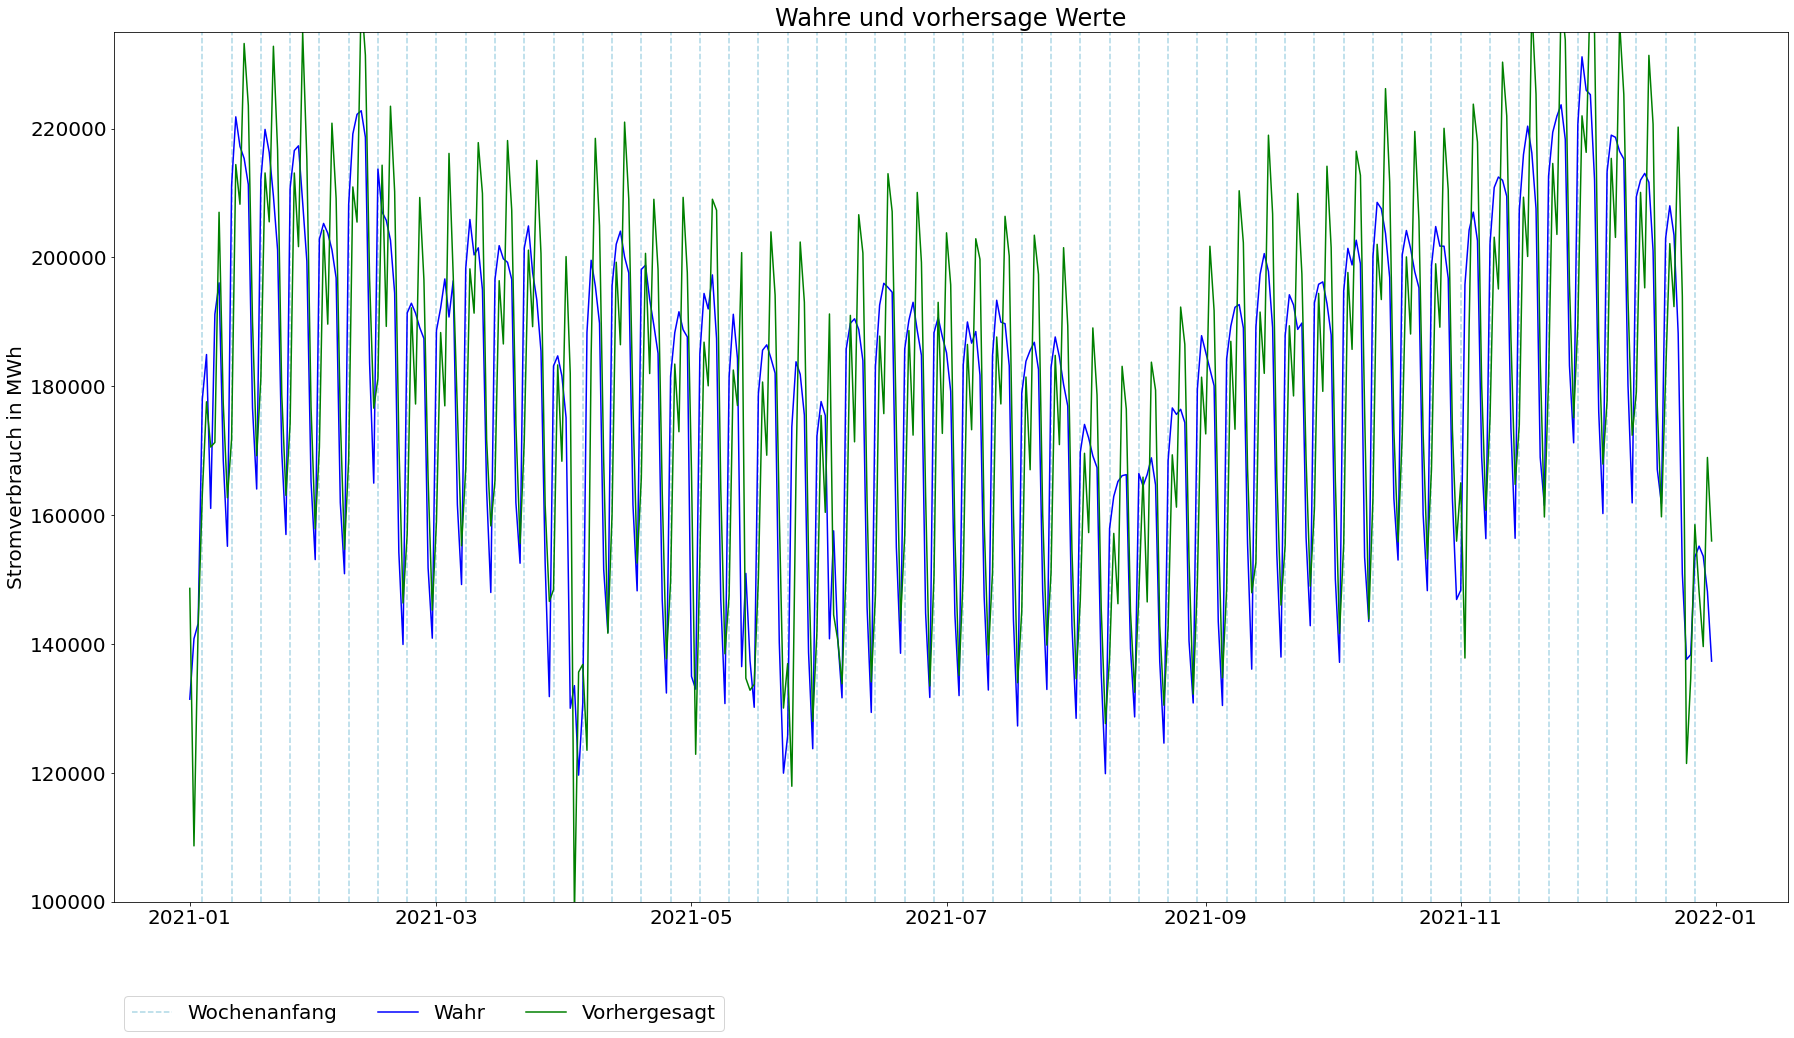

In [47]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test)

# <font size="7">Ergebnis</font>

<font size="5">Das ARIMA(2,0,2)(2,0,2)7 lässt sich durch zusätzliche Lags nicht verbessern, da stets Überanpassungen eintreten. Die zusätzlichen Lags rechtfertigen die höhere Komplexität nicht. Andererseits lässt sich das Modell auch nicht durch weniger Lags in seiner Komplexität reduzieren, ohne dass es zu Unteranpassungen kommt. Es hat sich außerdem gezeigt, dass alle vier Module (AR, MA, SAR und SMA) für das Modell relevant sind, da sich keines der Module ohne starke Unteranpassungen abschalten lässt. Die AR-Module sind allerdings etwas wichtiger. Außerdem tragen die saisonalen Module etwas mehr zum Modell bei als die nicht-saisonalen Module.<font>

## <font size="6">ARIMA(2,0,2)(2,0,2)7</font><a class="anchor" id="4-02a-ergebnis"></a>

<font size="5">Das ARIMA(2,0,2)(2,0,2)7 kann die Zeitreihe bereits gut abbilden, die wöchentliche und jährliche Saisonalität kann abgebildet werden. Es kommt allerdings stellenweise zu großen Abweichungen. DER MAPE liegt mit 3,21% unter der Baseline und dem Erfolgskriterium.  An den Autokorrelationen der Residuen lassen sich keine Systematiken bei den Abweichungen erkennen.<font>

In [48]:
#Nicht-saisonale und saisonale Ordnung festlegen
order = (2, 0, 2) #p, d, q
seasonal_order = (2, 0, 2, 7) #P, D, Q, m

#Modell mit Trainingsdaten erstellen
train_model_config = SARIMAX(endog=endog_train, order=order, seasonal_order=seasonal_order)
train_model = train_model_config.fit()

#Modell mit allen Daten erstllen und Konfiguration/Koeffizienten von ersten Modell übernehmen (kein neues Training)
model_config = SARIMAX(endog=endog, order=order, seasonal_order=seasonal_order)
model = model_config.filter(train_model.params)

#Modell ausgeben
print(model.summary())
print()

                                     SARIMAX Results                                     
Dep. Variable:                         verbrauch   No. Observations:                 2557
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood                3037.805
Date:                           Thu, 03 Feb 2022   AIC                          -6057.610
Time:                                   11:15:04   BIC                          -6004.991
Sample:                               01-01-2015   HQIC                         -6038.529
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9434      0.050     18.823      0.000       0.845       1.042
ar.L2          0.0162      0.045      0.358

      Vorhersage
R2          0.89
MAE       5379.0
MSE   77296958.0
RMSE      8792.0
                
MAPE      3.21 %


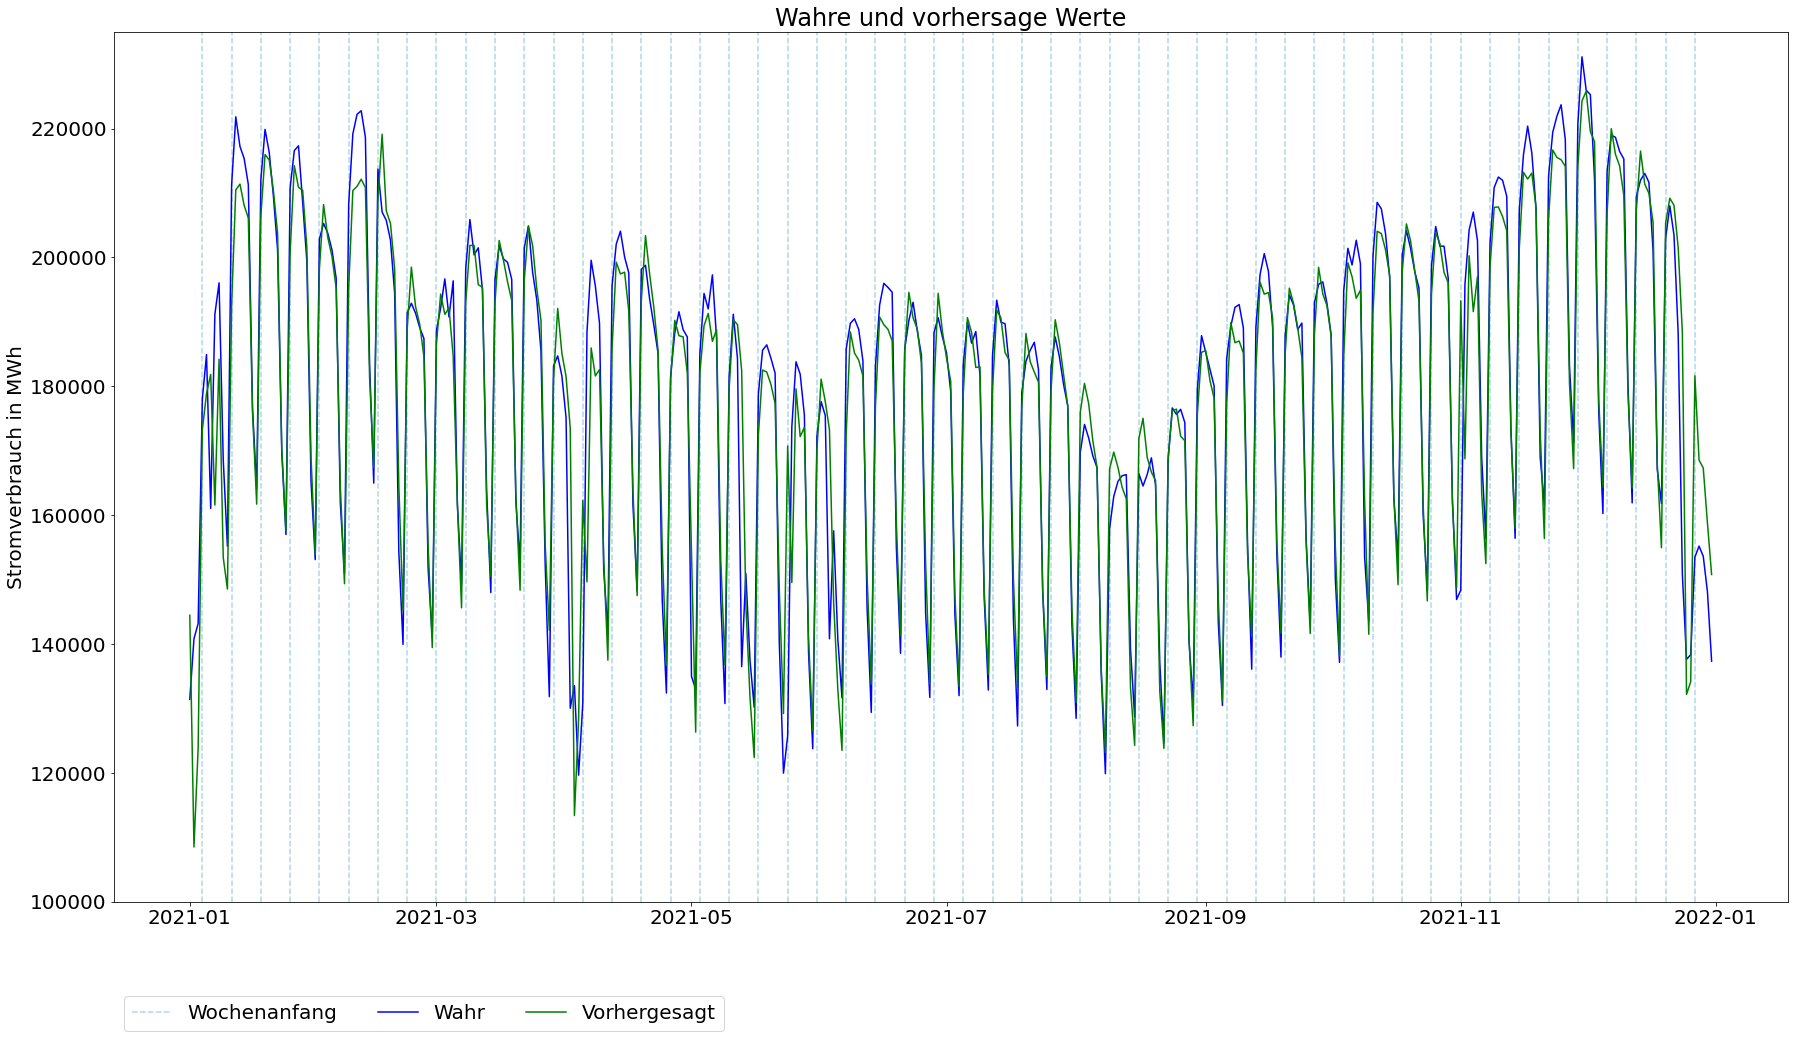

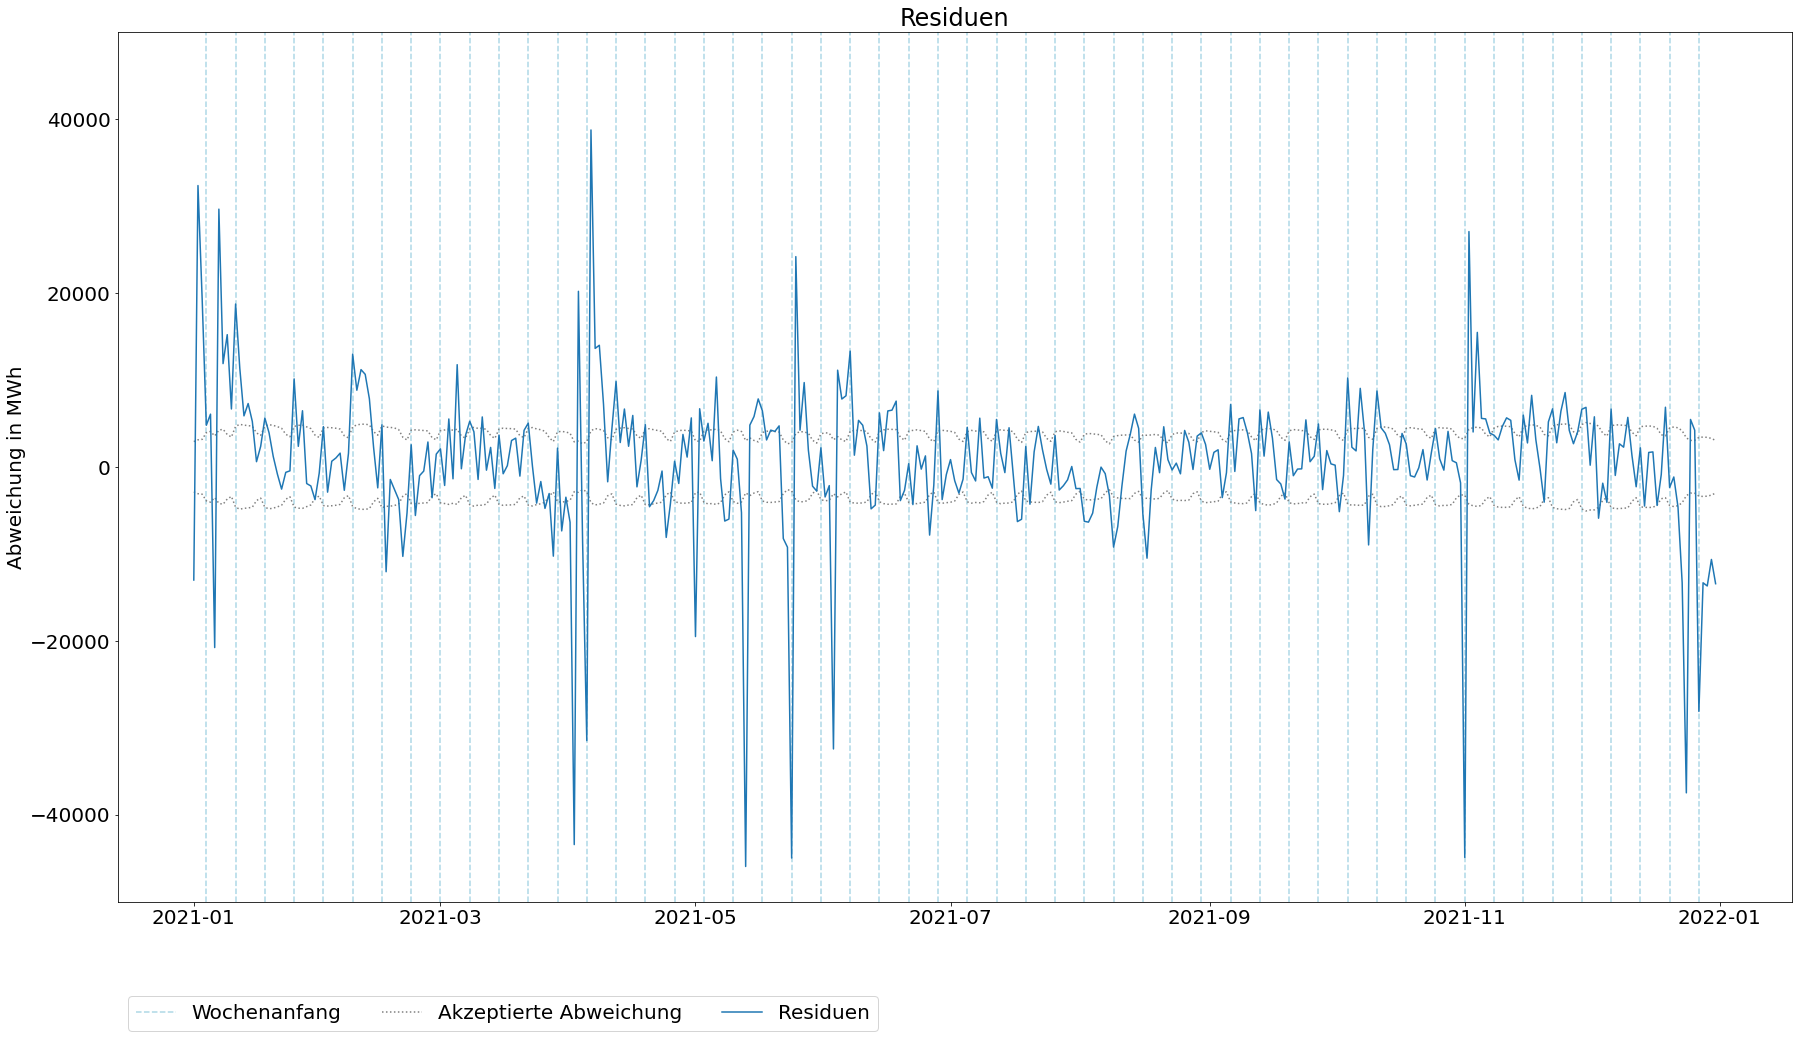

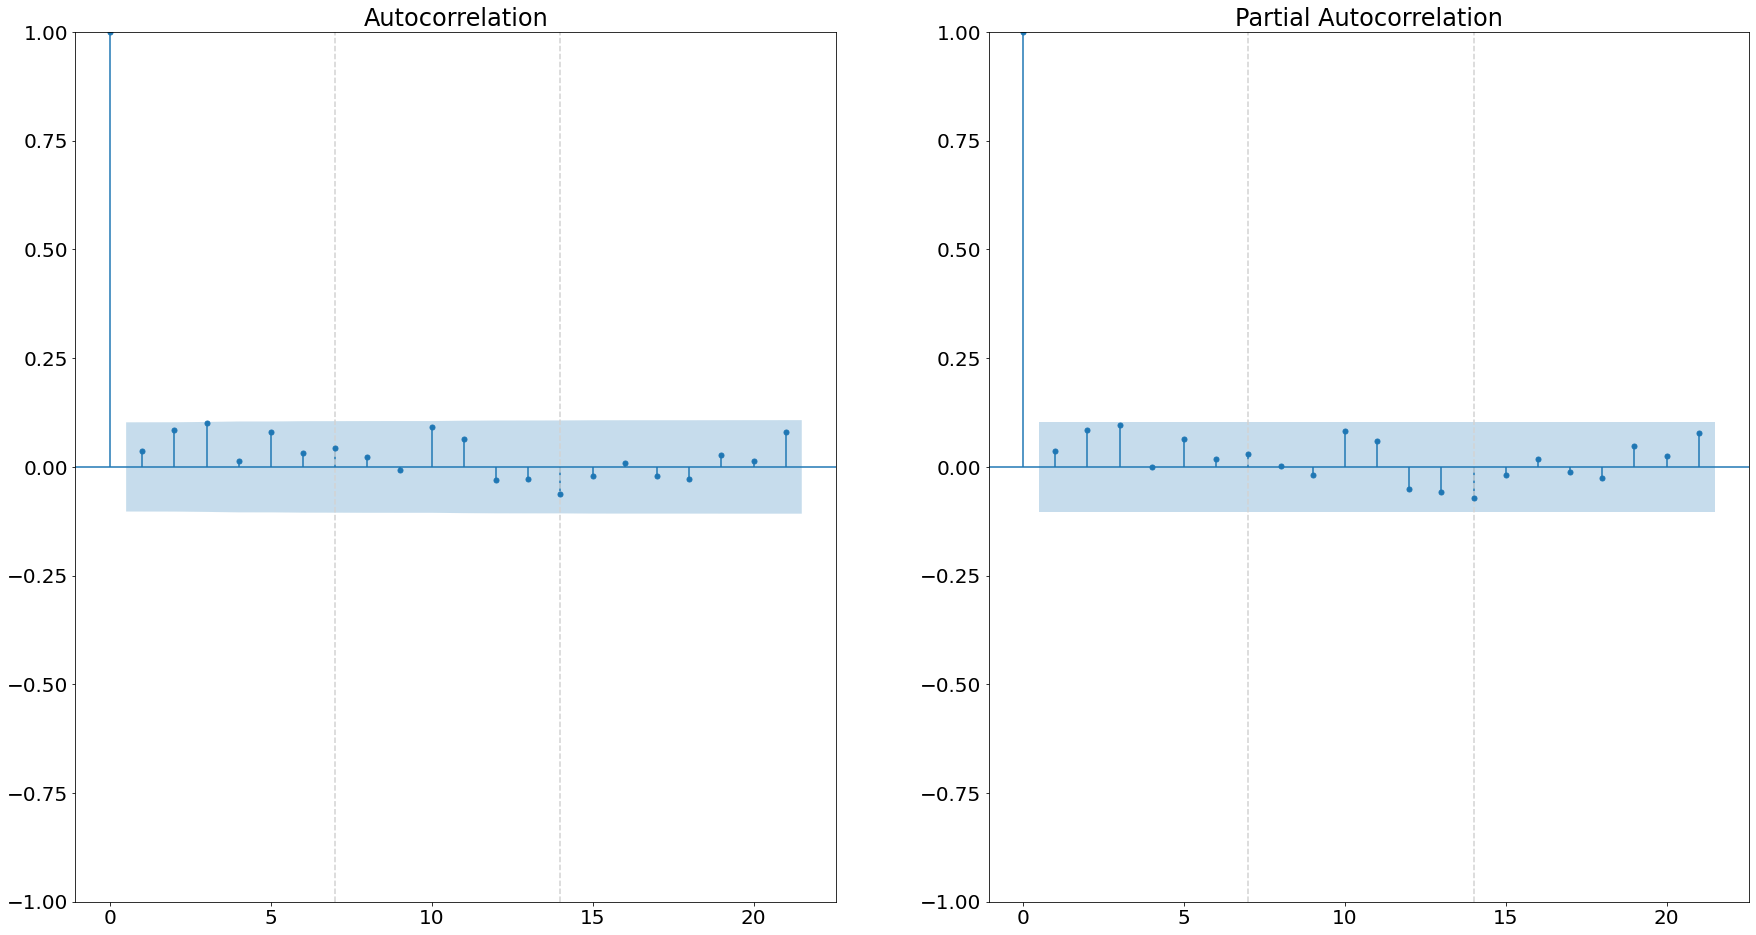

In [49]:
#Vorhersage erzeugen
scaled_preds_test = model.predict(start="2021-01-1", end="2021-12-31", dynamic=False).values

#Vorhersagen mit echten Werten vergleichen
functions.custom_metrics_arima(y_true, scaled_preds_test, True, True, True, True)